In [117]:
# Separate Polynomial Regression for each county
# Still need to figure out how to use spatial data

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from xgboost import XGBRegressor
from prophet import Prophet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [119]:
scaler_min = MinMaxScaler()
scaler_std = StandardScaler()
scaler_rob = RobustScaler()
scaler_pow = PowerTransformer()

In [120]:
def rmse(x, y):
    return np.sqrt(mean_squared_error(x, y))

In [121]:
# Load the dataset
df = pd.read_csv("hungary_chickenpox.csv")

df.head(3)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   
2  17/01/2005        96       44    31     86      93        30     93    84   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  

[3 rows x 21 columns]

In [122]:
# Data preprocessing

# TO DO 1: figure out PCA
# TO DO 2: figure out how to incorporate spatial data (try 3d dataframe)

In [123]:
df.insert(0, "Week", [i for i in range(1, len(df) + 1)])

df.head(3)

Week        Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   
0     1  03/01/2005       168       79    30    173     169        42    136  \
1     2  10/01/2005       157       60    30     92     200        53     51   
2     3  17/01/2005        96       44    31     86      93        30     93   

   GYOR  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0   120  ...   130       57       2   178      66        64     11   29  \
1    70  ...    80       50      29   141      48        29     58   53   
2    84  ...    64       46       4   157      33        33     24   18   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  

[3 rows x 22 columns]

In [124]:
county_list = df.columns.to_list()
county_list.remove('Week')
county_list.remove('Date')

county_list

['BUDAPEST',
 'BARANYA',
 'BACS',
 'BEKES',
 'BORSOD',
 'CSONGRAD',
 'FEJER',
 'GYOR',
 'HAJDU',
 'HEVES',
 'JASZ',
 'KOMAROM',
 'NOGRAD',
 'PEST',
 'SOMOGY',
 'SZABOLCS',
 'TOLNA',
 'VAS',
 'VESZPREM',
 'ZALA']

In [125]:
# creating the ML model

In [126]:
x = df['Week'].values.reshape(-1, 1) #extracting week to be the input variable x
y_df = df[county_list] # each county to be a separate y variable

In [127]:
x_scaled_min = scaler_min.fit_transform(x) # normalizing the x variable (y will be normalised later [each county separately])
x_scaled_pow = scaler_pow.fit_transform(x)

In [128]:
# Split the x dataset into train and test sets
x_train_min, x_test_min = train_test_split(x_scaled_min, test_size=0.2, random_state=101)
x_train_pow, x_test_pow = train_test_split(x_scaled_pow, test_size=0.2, random_state=101)

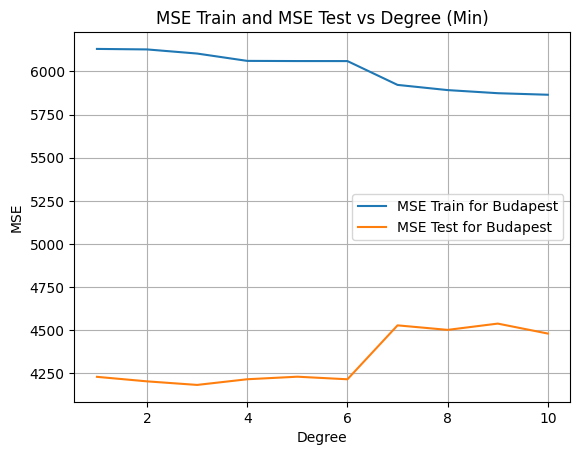

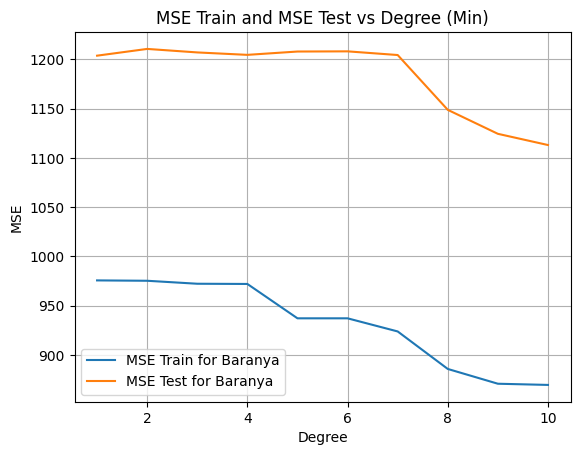

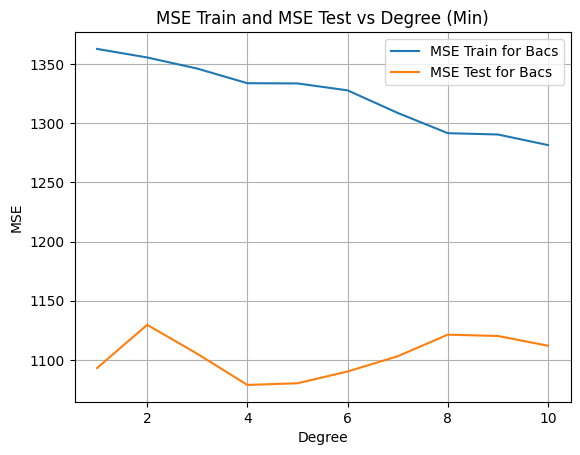

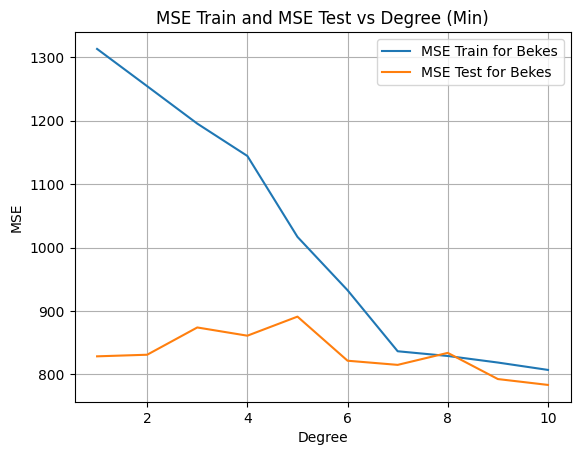

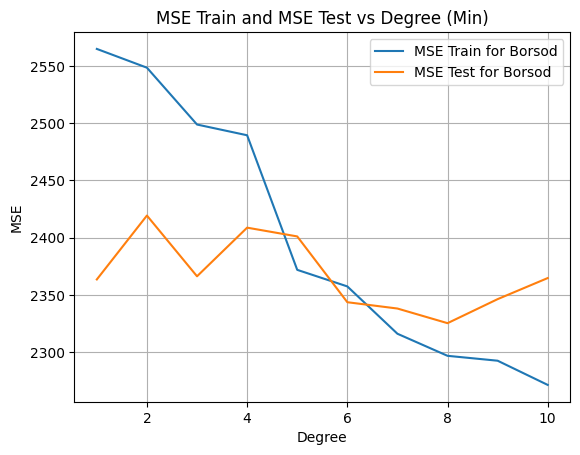

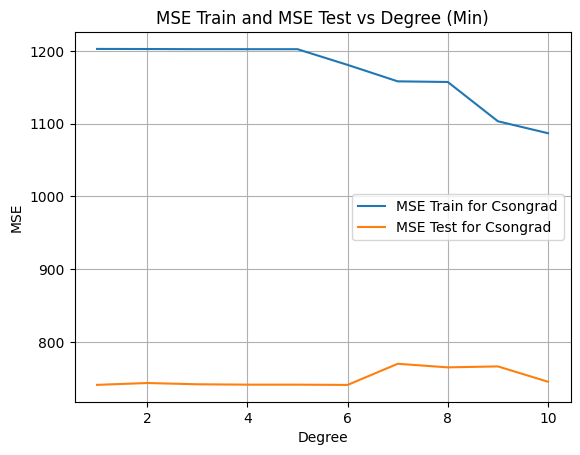

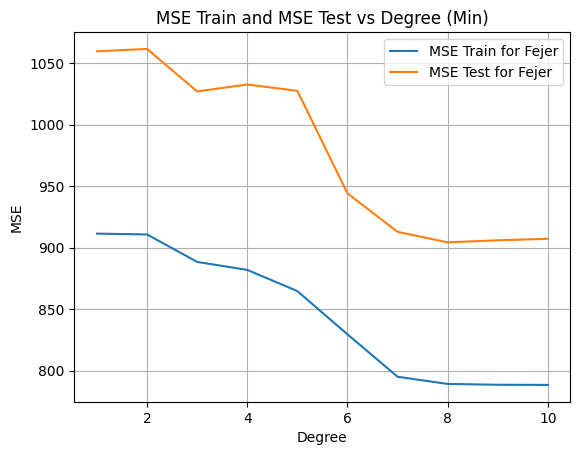

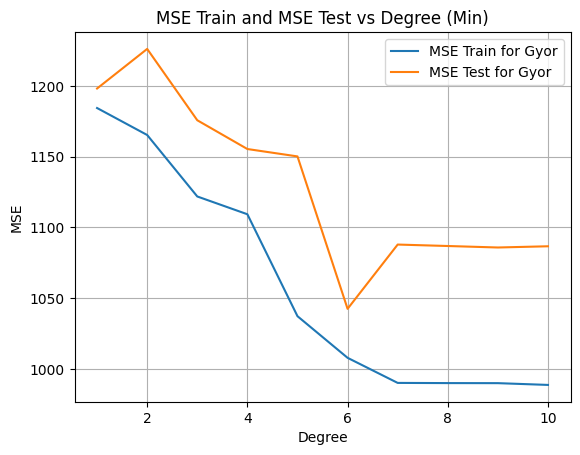

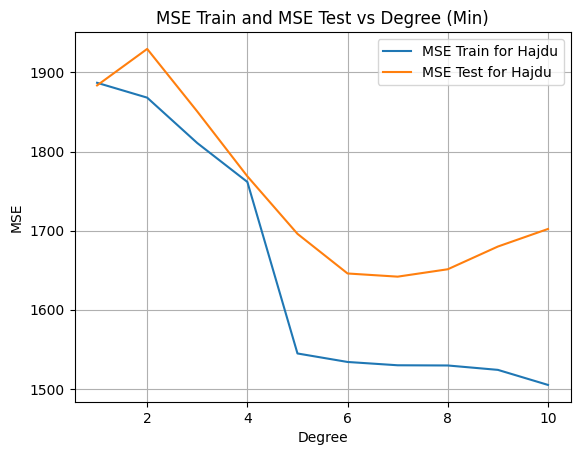

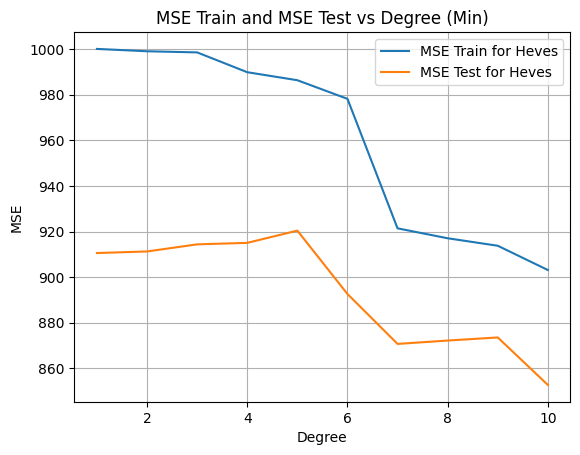

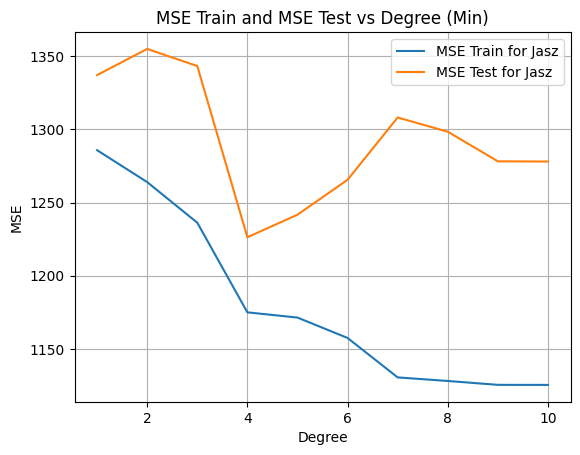

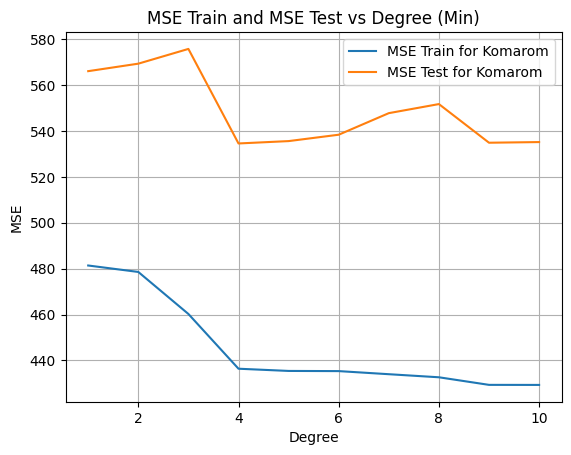

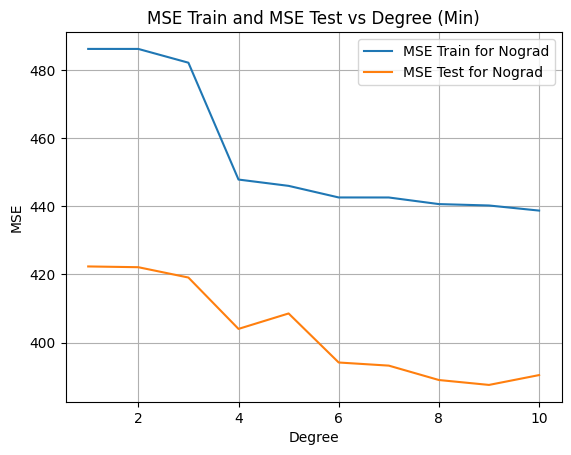

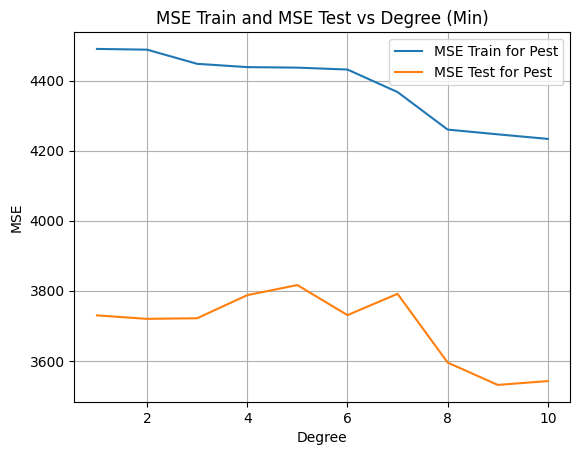

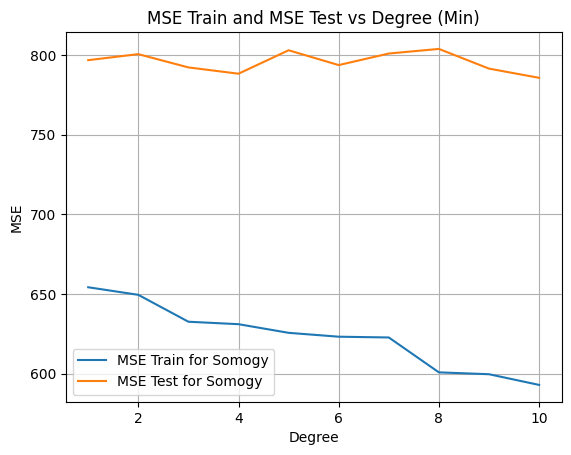

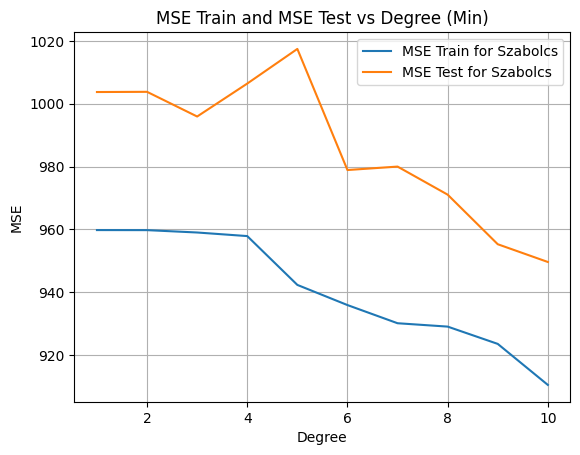

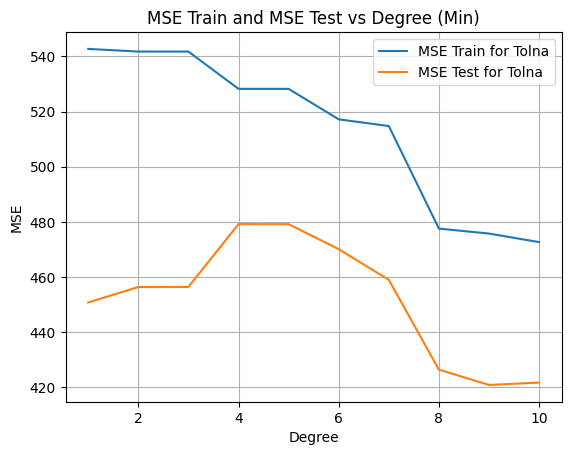

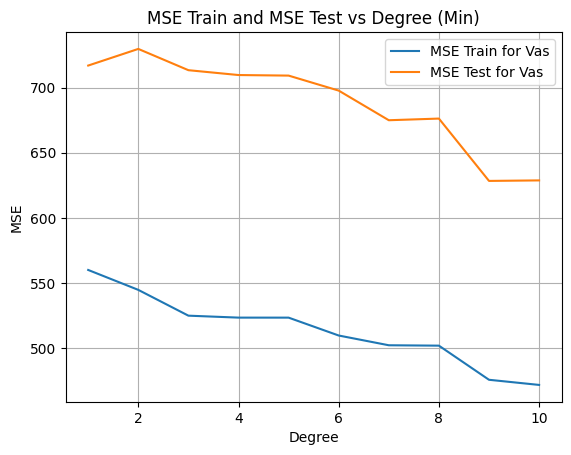

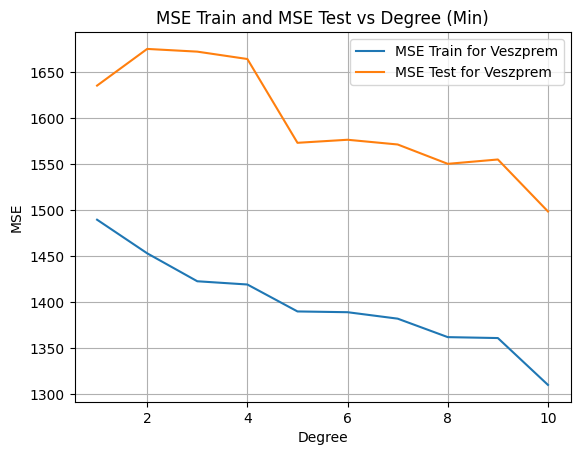

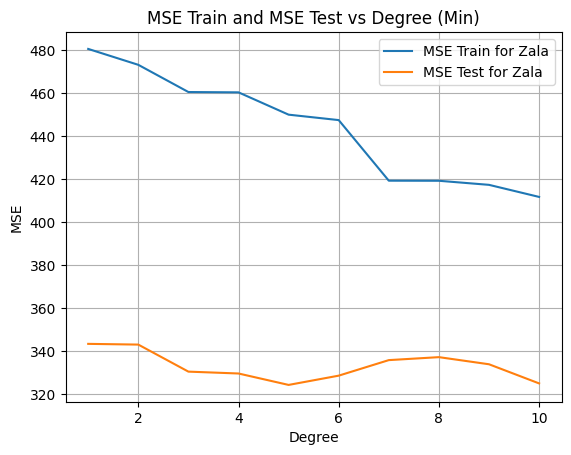

In [129]:
degrees = range(1, 11)
mse_test_min = []
mse_train_min = []

best_degrees_min = []

for county in county_list:

    mse_test_county_min = []
    mse_train_county_min = []
    mape_test_county_min = []
    
    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        # Normalize the target variable
        y_scaled_min = scaler_min.fit_transform(y.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_min, y_test_min = train_test_split(y_scaled_min, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_min = poly_features.fit_transform(x_train_min)
        x_test_poly_min = poly_features.transform(x_test_min)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_min, y_train_min)

        # Predict y values for train and test sets
        y_train_pred_min = model.predict(x_train_poly_min)
        y_test_pred_min = model.predict(x_test_poly_min)

        # performing inverse transform so that we have uniform scaling for errors
        y_train_pred_min = scaler_min.inverse_transform(y_train_pred_min.reshape(-1, 1))
        y_train_min = scaler_min.inverse_transform(y_train_min.reshape(-1, 1))

        y_test_pred_min = scaler_min.inverse_transform(y_test_pred_min.reshape(-1, 1))
        y_test_min = scaler_min.inverse_transform(y_test_min.reshape(-1, 1))

        mse_train_county_min.append(mean_squared_error(y_train_pred_min, y_train_min))
        mse_test_county_min.append(mean_squared_error(y_test_pred_min, y_test_min))

    mse_test_min.append(np.min(mse_test_county_min))
    mse_train_min.append(mse_test_county_min[np.argmin(mse_test_county_min)])
    best_degrees_min.append(np.argmin(mse_test_county_min) + 1)


    plt.plot(degrees, mse_train_county_min, label=f'MSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, mse_test_county_min, label=f'MSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('MSE Train and MSE Test vs Degree (MinMax Scaler)')
    plt.legend()
    plt.grid(True)
    plt.show()

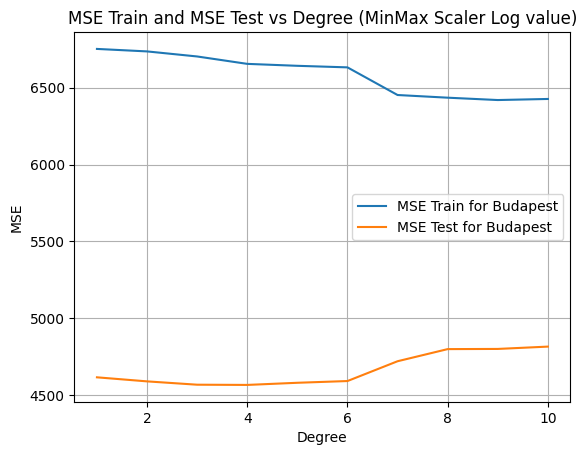

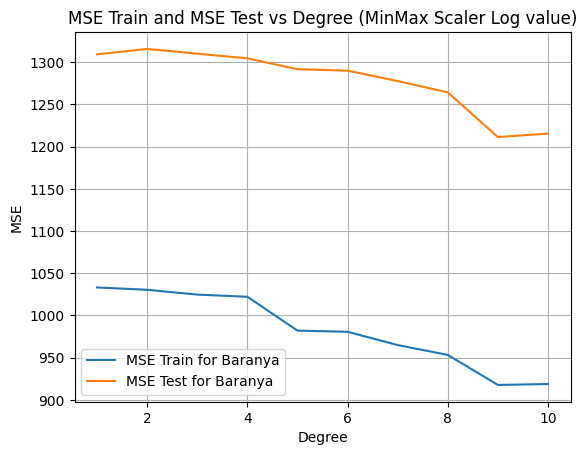

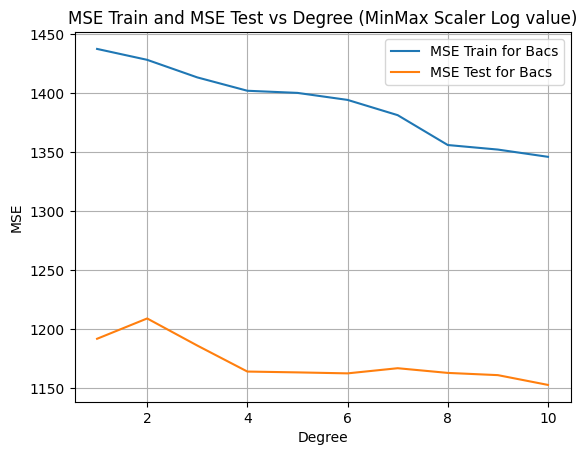

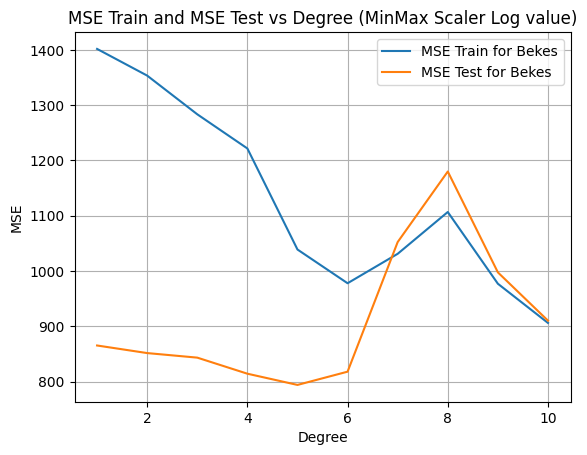

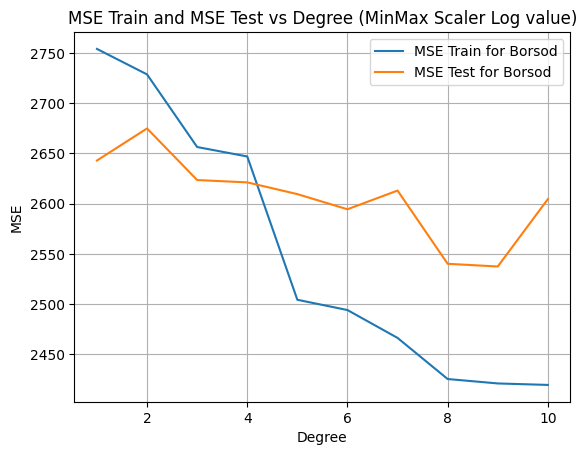

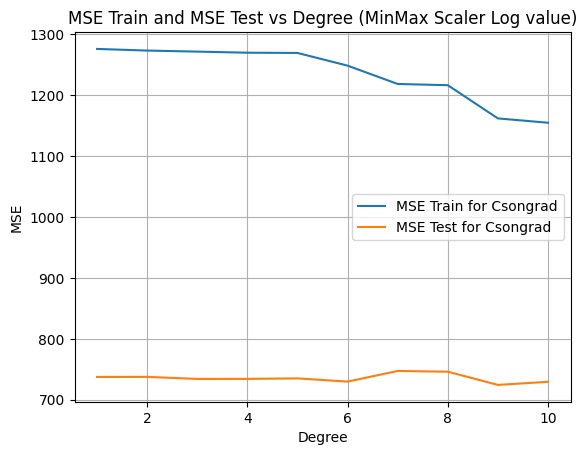

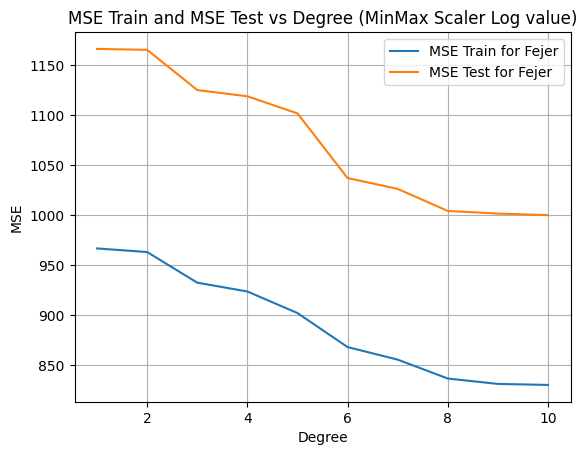

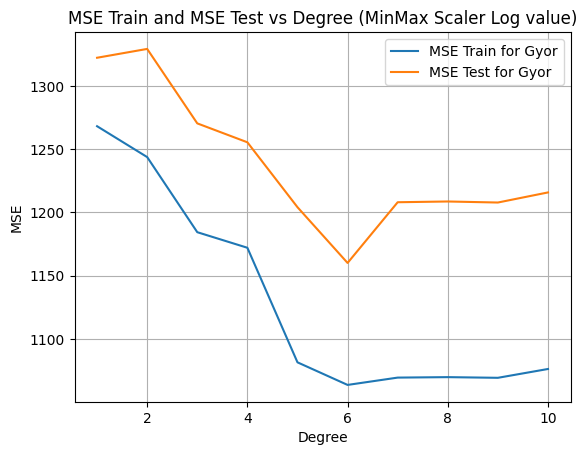

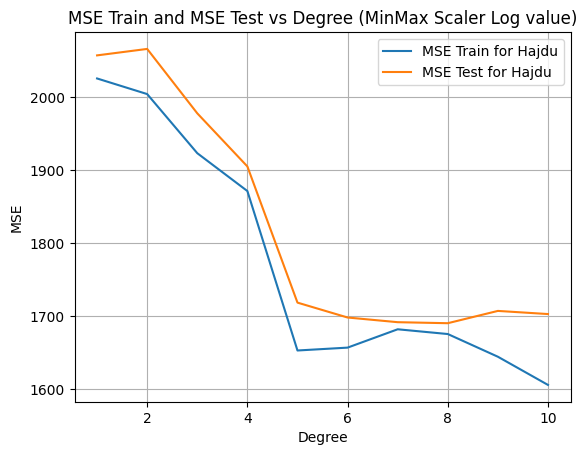

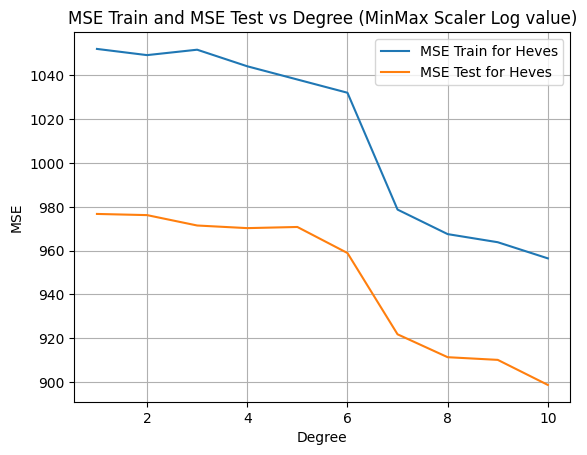

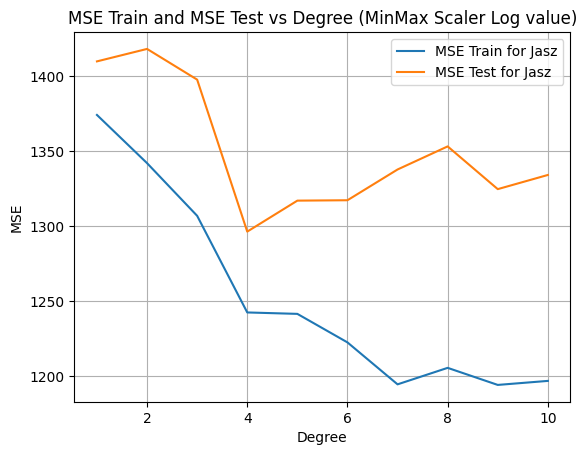

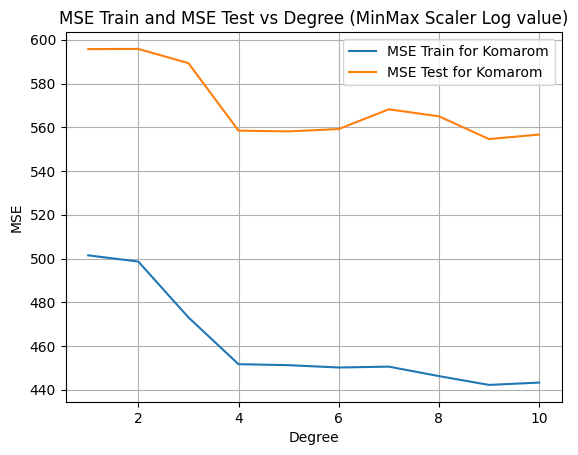

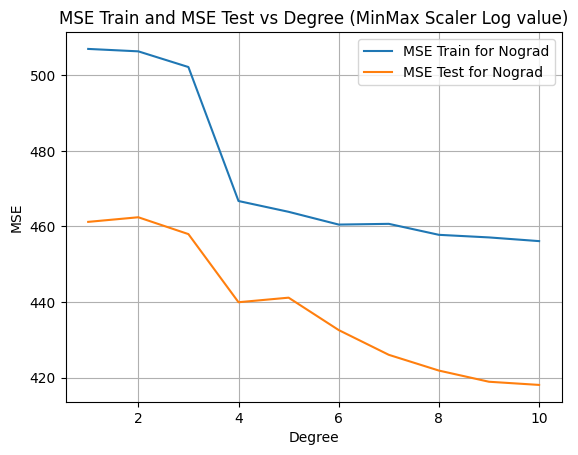

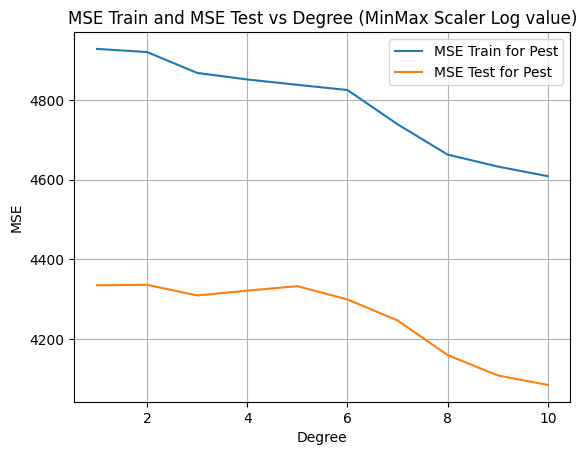

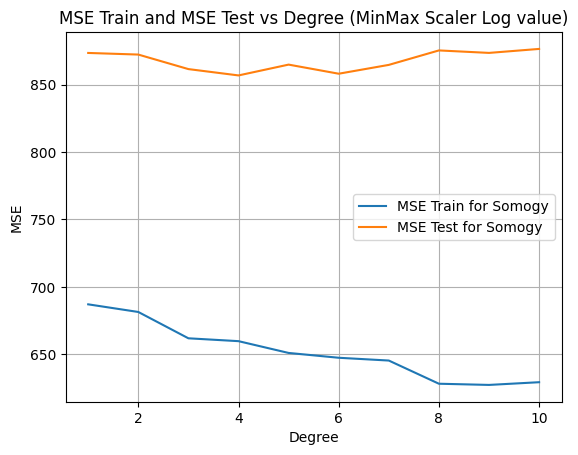

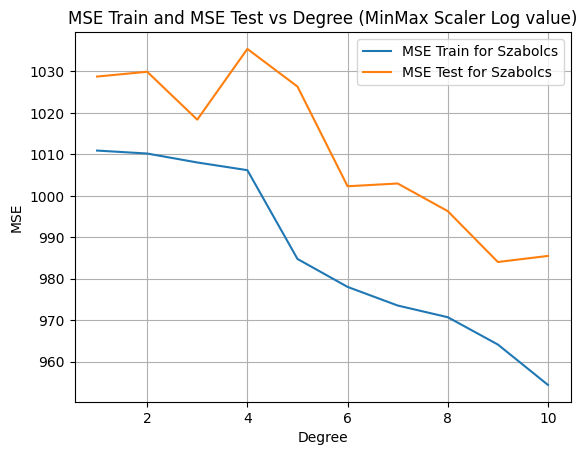

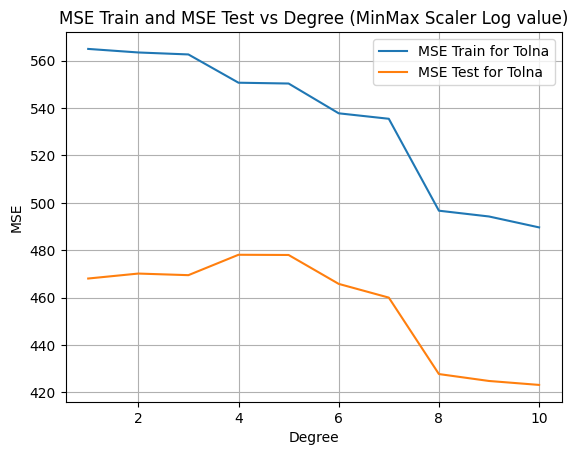

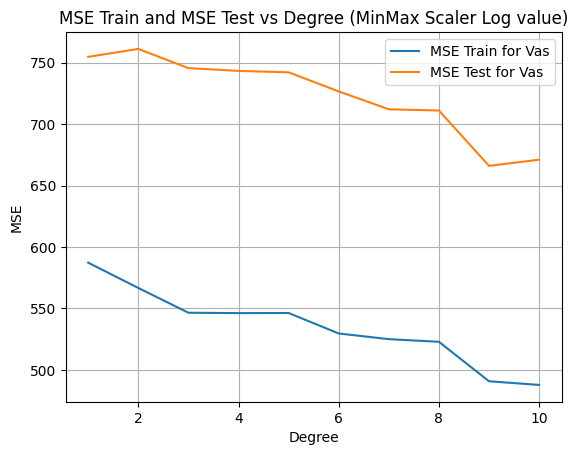

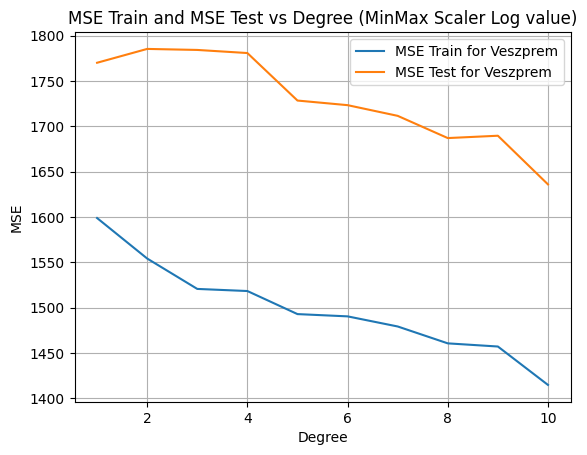

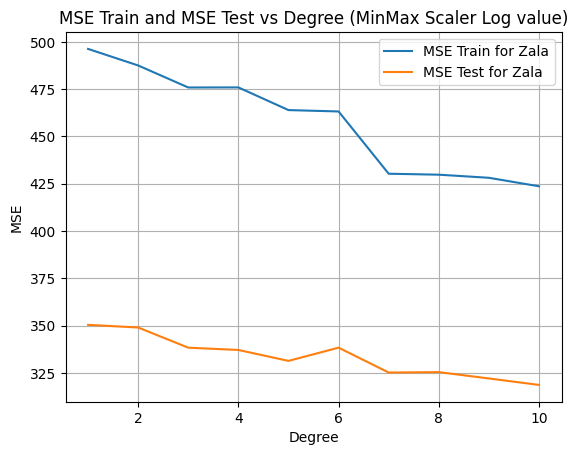

In [135]:
degrees = range(1, 11)
mse_test_min_log = []
mse_train_min_log = []

best_degrees_min_log = []

for county in county_list:

    mse_test_county_min_log = []
    mse_train_county_min_log = []  

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        y += 1

        # Logarithmic transformation of y
        y_log = np.log(y)

        # Normalize the target variable
        y_scaled_min_log = scaler_min.fit_transform(y_log.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_min_log, y_test_min_log = train_test_split(y_scaled_min_log, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_min = poly_features.fit_transform(x_train_min)
        x_test_poly_min = poly_features.transform(x_test_min)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_min, y_train_min_log)

        # Predict y values for train and test sets
        y_train_pred_min_log = model.predict(x_train_poly_min)
        y_test_pred_min_log = model.predict(x_test_poly_min)

        # Performing inverse transform so that we have uniform scaling for errors
        y_train_pred_min_log = scaler_min.inverse_transform(y_train_pred_min_log.reshape(-1, 1))
        y_train_min_log = scaler_min.inverse_transform(y_train_min_log.reshape(-1, 1))

        y_test_pred_min_log = scaler_min.inverse_transform(y_test_pred_min_log.reshape(-1, 1))
        y_test_min_log = scaler_min.inverse_transform(y_test_min_log.reshape(-1, 1))

        # Detransforming y_pred_min and y_test_min
        y_train_pred_min_log = np.exp(y_train_pred_min_log)
        y_test_pred_min_log = np.exp(y_test_pred_min_log)

        y_train_min_log = np.exp(y_train_min_log)
        y_test_min_log = np.exp(y_test_min_log)

        # calculating errors
        mse_train_county_min_log.append(mean_squared_error(y_train_pred_min_log, y_train_min_log))
        mse_test_county_min_log.append(mean_squared_error(y_test_pred_min_log, y_test_min_log))
        
    mse_test_min_log.append(np.min(mse_test_county_min_log))
    mse_train_min_log.append(mse_test_county_min_log[np.argmin(mse_test_county_min_log)])
    best_degrees_min_log.append(np.argmin(mse_test_county_min_log) + 1)

    plt.plot(degrees, mse_train_county_min_log, label=f'MSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, mse_test_county_min_log, label=f'MSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('MSE Train and MSE Test vs Degree (MinMax Scaler Log value)')
    plt.legend()
    plt.grid(True)
    plt.show()


[4566.153922402796,
 1211.289143666845,
 1152.7103640234022,
 793.8623956595602,
 2537.3874621296804,
 724.3549021193626,
 999.9737047987683,
 1160.0197920466126,
 1690.3845729833574,
 898.7078535071988,
 1296.5418701316157,
 554.6186220322394,
 418.07314573655776,
 4085.2358340866476,
 856.763120267122,
 984.0413871430815,
 423.1749691260622,
 666.0525384504256,
 1635.9839327512748,
 318.6573487047863]

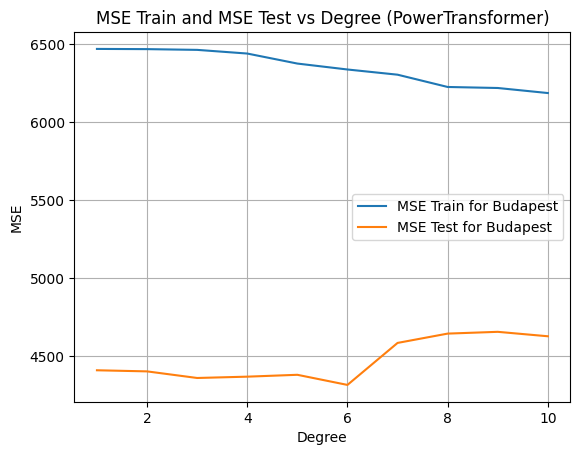

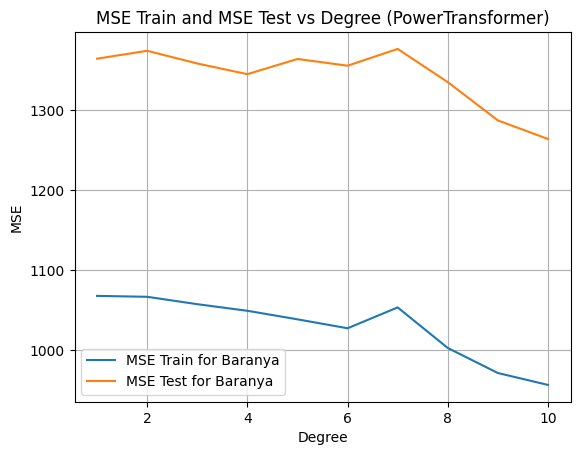

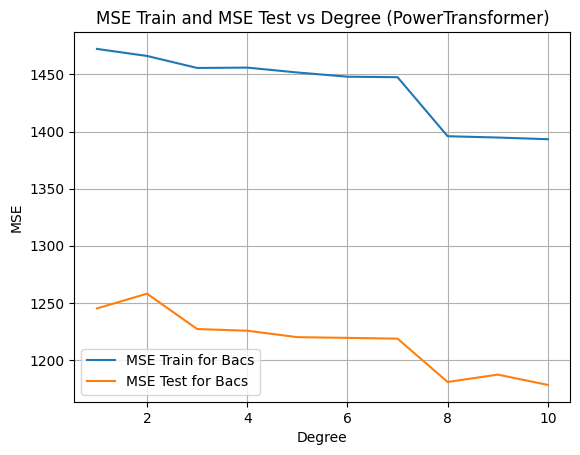

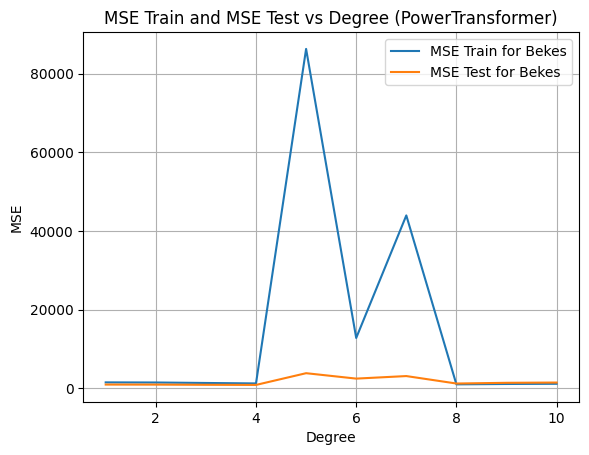

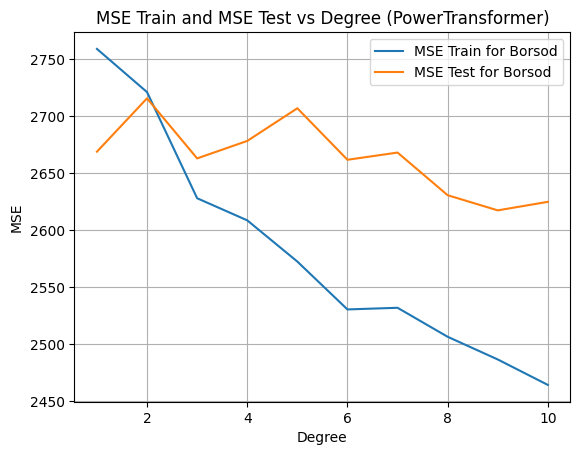

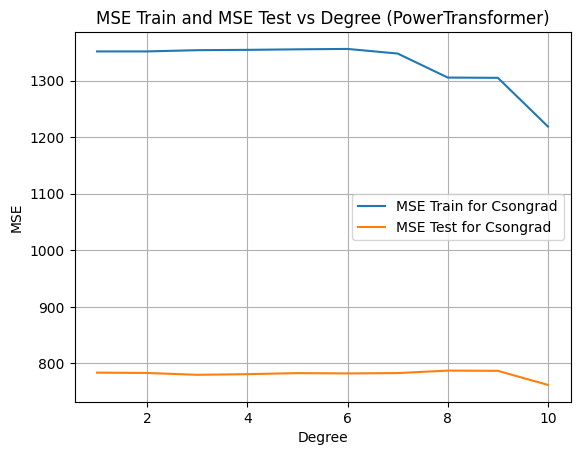

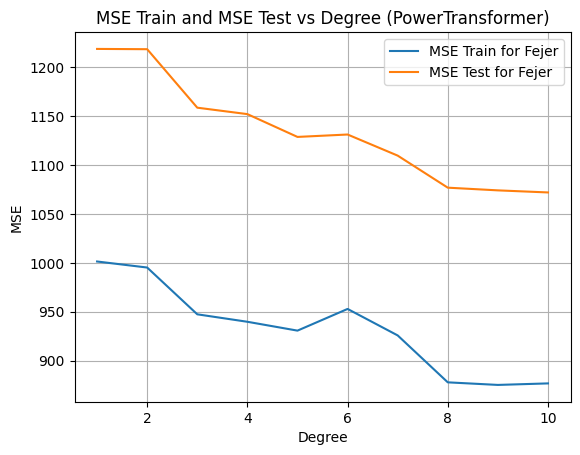

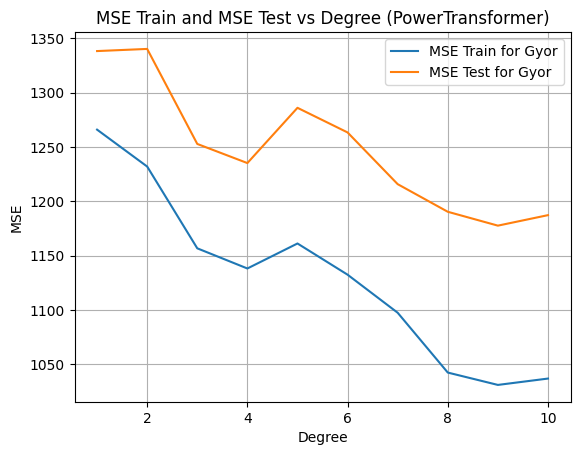

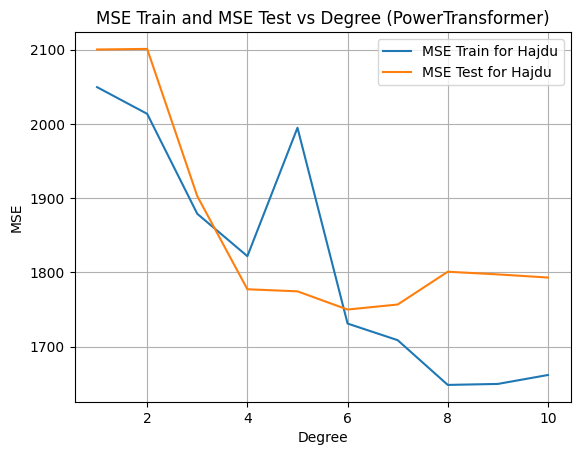

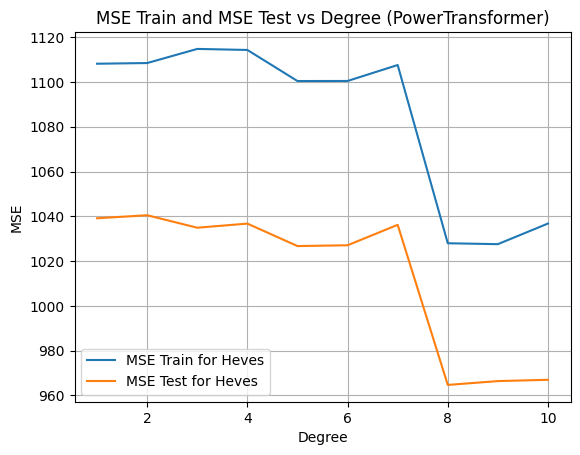

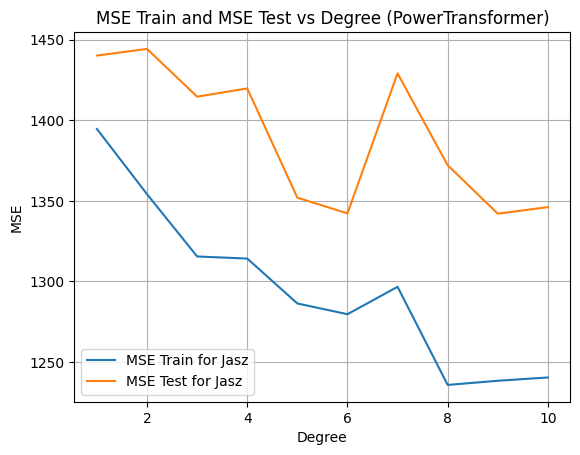

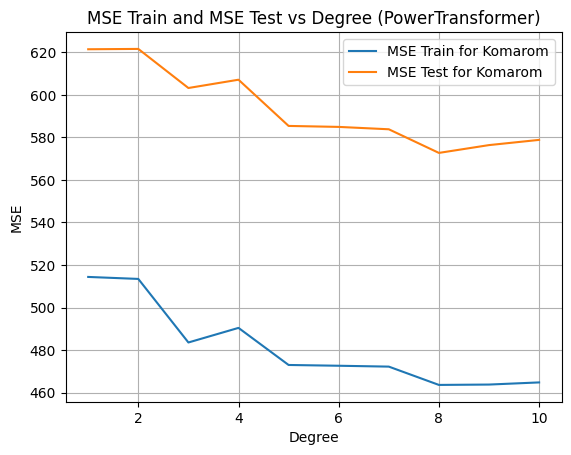

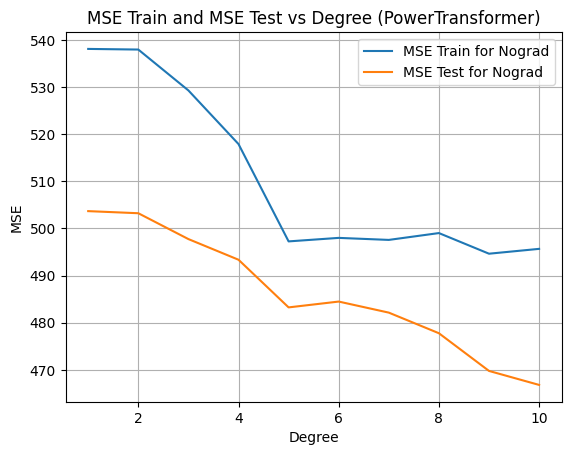

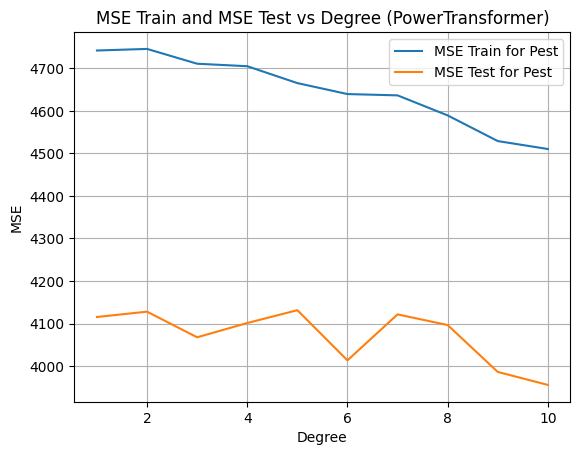

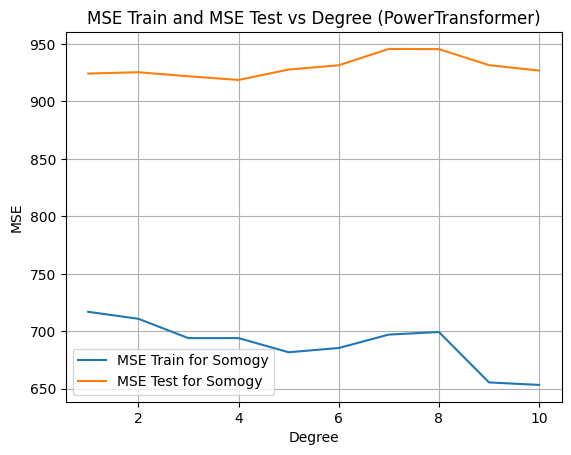

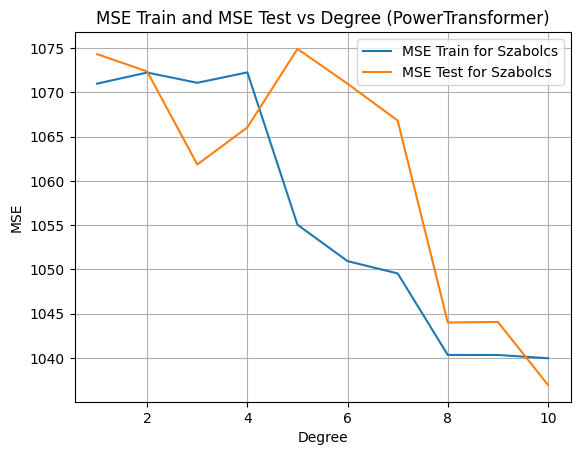

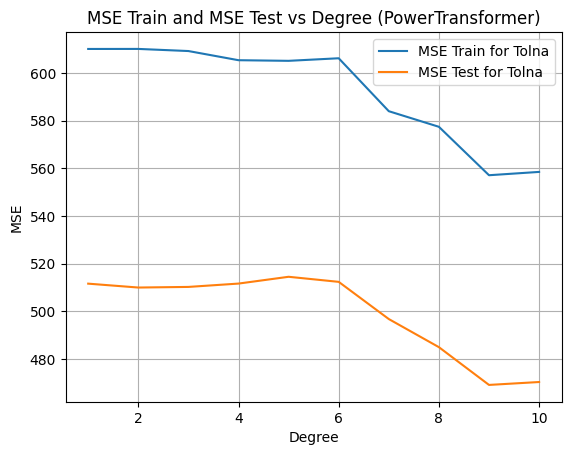

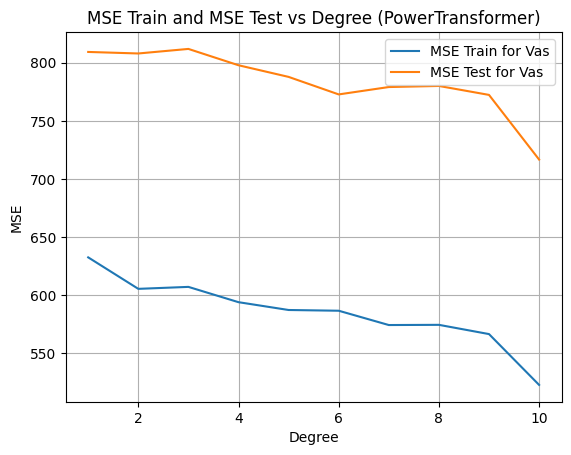

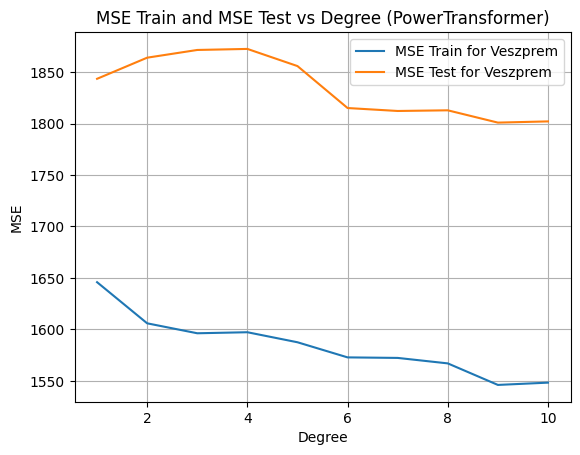

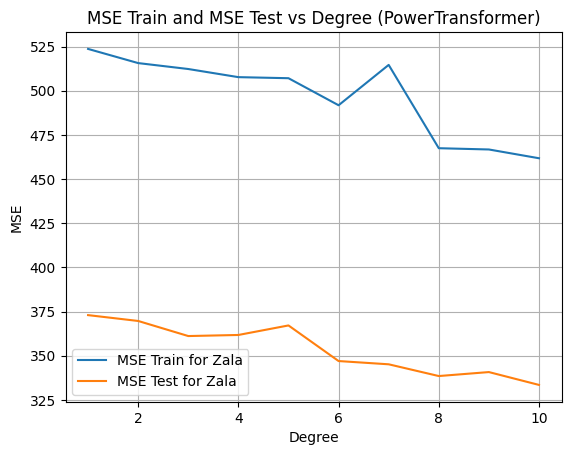

In [131]:
mse_test_pow = []
mse_train_pow = []
mape_test_pow = []
r2_test_pow = []

best_degrees_pow = []

for county in county_list:

    mse_test_county_pow = []
    mse_train_county_pow = []
    mape_test_county_pow = []
    r2_test_county_pow = []

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        # Normalize the target variable
        y_scaled_pow = scaler_pow.fit_transform(y.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_pow, y_test_pow = train_test_split(y_scaled_pow, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_pow = poly_features.fit_transform(x_train_pow)
        x_test_poly_pow = poly_features.transform(x_test_pow)

        # Fit polynomial regression model POW
        model = LinearRegression()
        model.fit(x_train_poly_pow, y_train_pow)

        # Predict y values for train and test sets
        y_train_pred_pow = model.predict(x_train_poly_pow)
        y_test_pred_pow = model.predict(x_test_poly_pow)

        # performing inverse transform so that we have uniform scaling for errors
        y_train_pred_pow = scaler_pow.inverse_transform(y_train_pred_pow.reshape(-1, 1))
        y_train_pow = scaler_pow.inverse_transform(y_train_pow.reshape(-1, 1))

        y_test_pred_pow = scaler_pow.inverse_transform(y_test_pred_pow.reshape(-1, 1))
        y_test_pow = scaler_pow.inverse_transform(y_test_pow.reshape(-1, 1))

        mse_train_county_pow.append(mean_squared_error(y_train_pred_pow, y_train_pow))
        mse_test_county_pow.append(mean_squared_error(y_test_pred_pow, y_test_pow))
        mape_test_county_pow.append(mean_absolute_percentage_error(y_test_pred_pow, y_test_pow))
        r2_test_county_pow.append(r2_score(y_test_pred_pow, y_test_pow))

    mse_test_pow.append(np.min(mse_test_county_pow))
    mse_train_pow.append(mse_test_county_pow[np.argmin(mse_test_county_pow)])
    best_degrees_pow.append(np.argmin(mse_test_county_pow) + 1)
    mape_test_pow.append(mape_test_county_pow[np.argmin(mse_test_county_pow)])
    r2_test_pow.append(r2_test_county_pow[np.argmin(mse_test_county_pow)])

    plt.plot(degrees, mse_train_county_pow, label=f'MSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, mse_test_county_pow, label=f'MSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('MSE Train and MSE Test vs Degree (PowerTransformer)')
    plt.legend()
    plt.grid(True)
    plt.show()

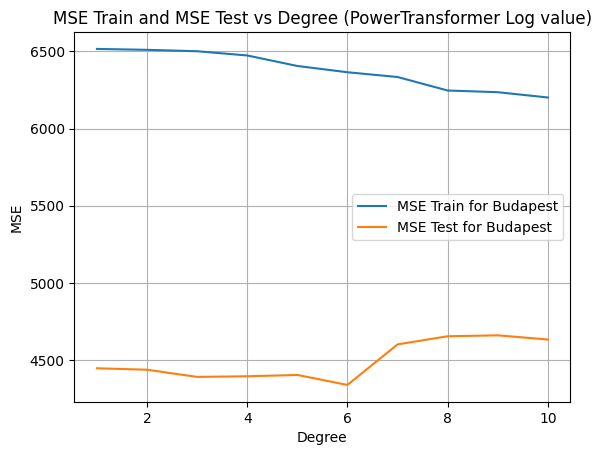

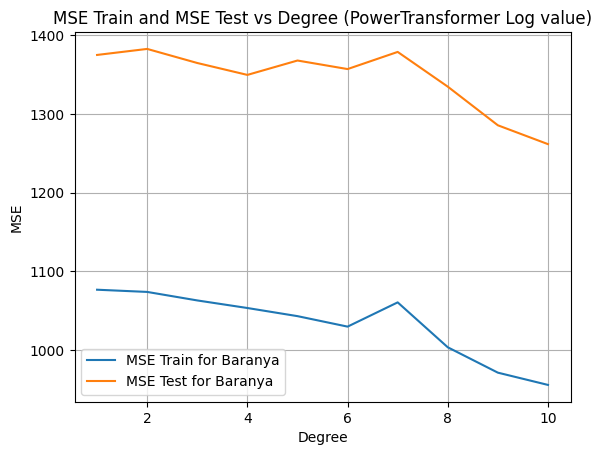

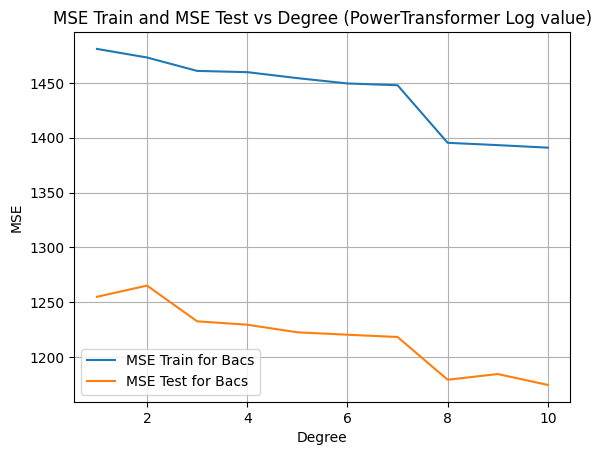

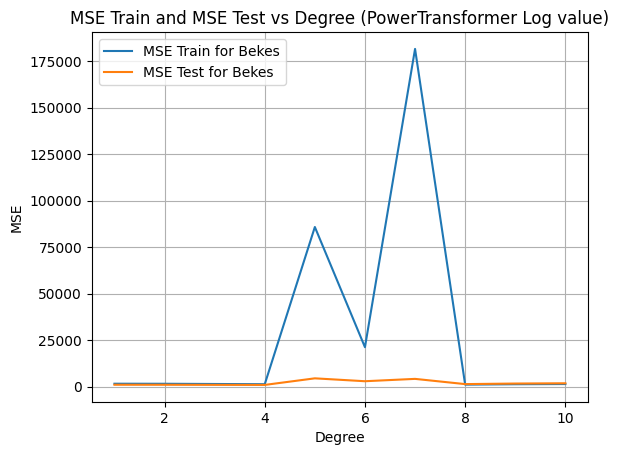

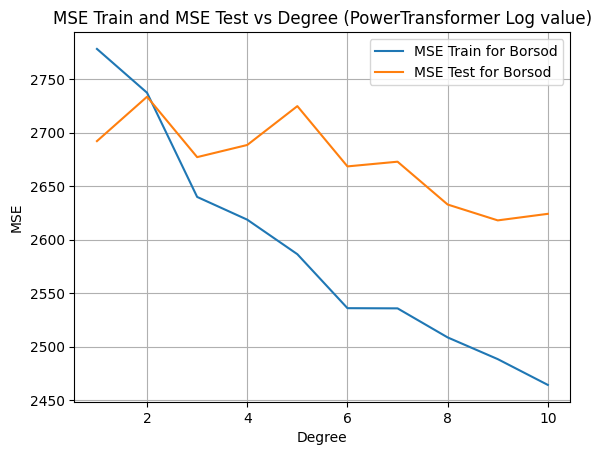

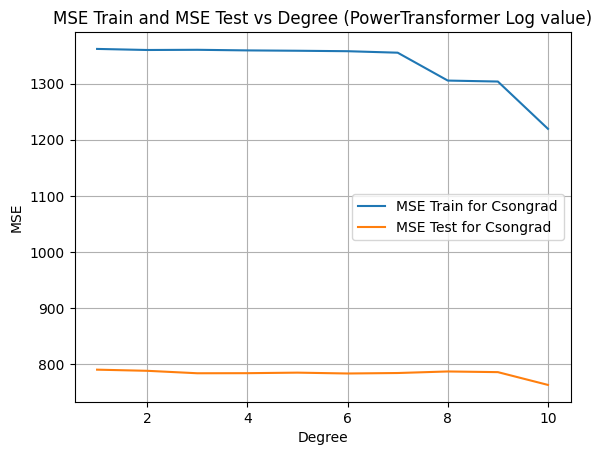

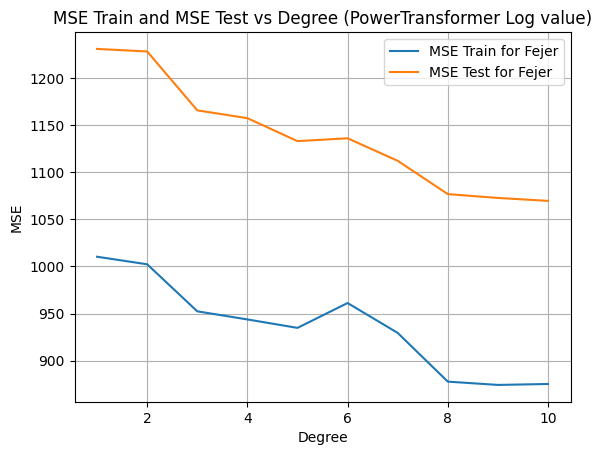

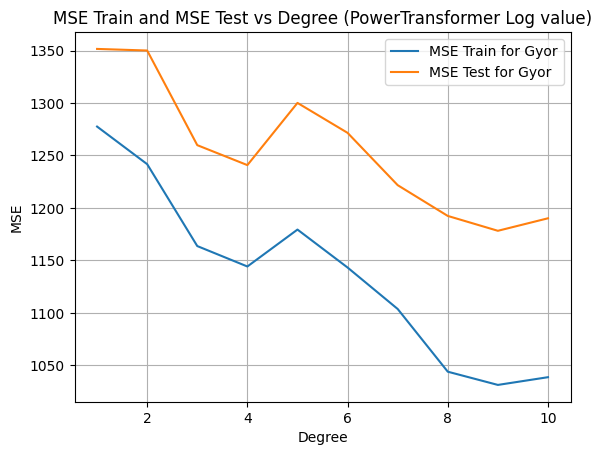

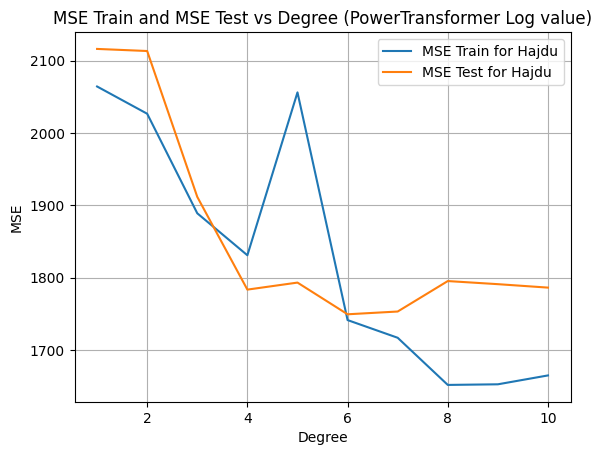

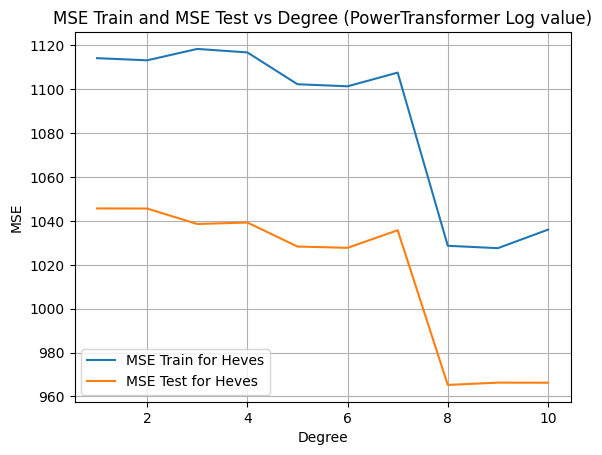

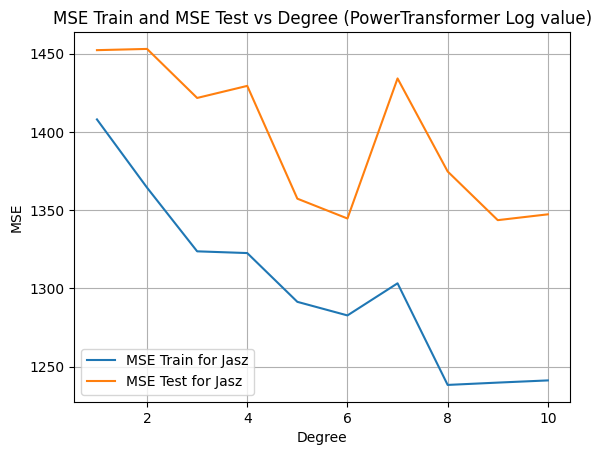

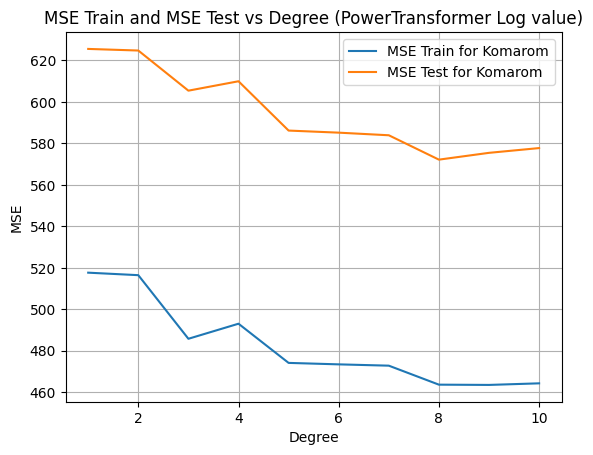

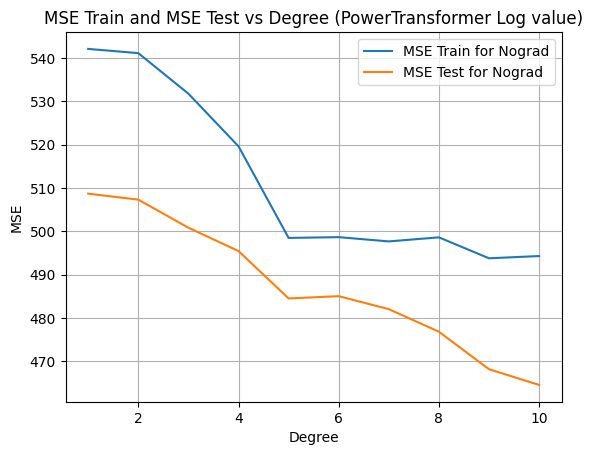

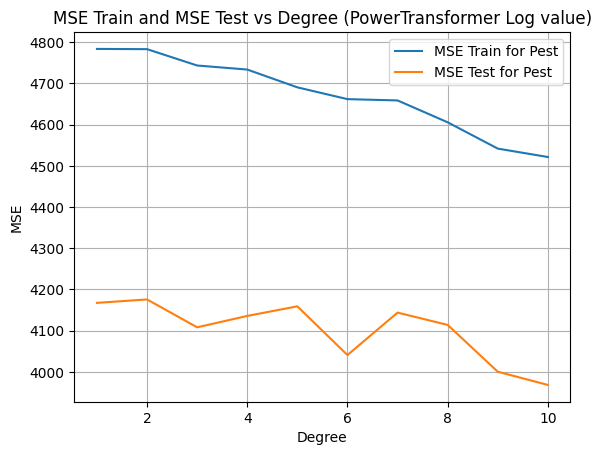

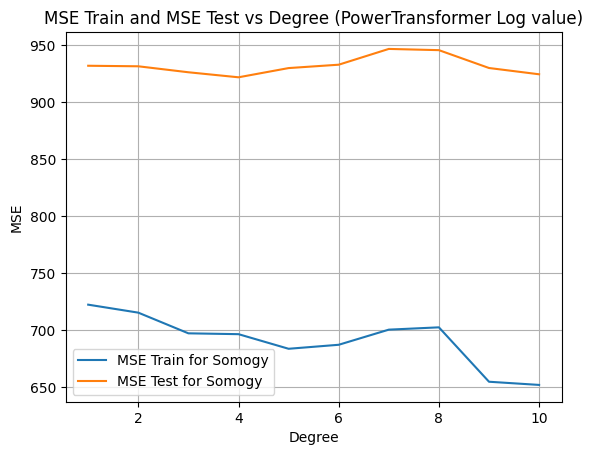

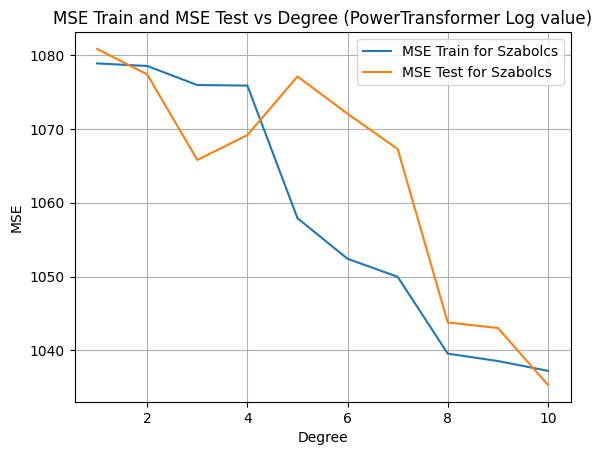

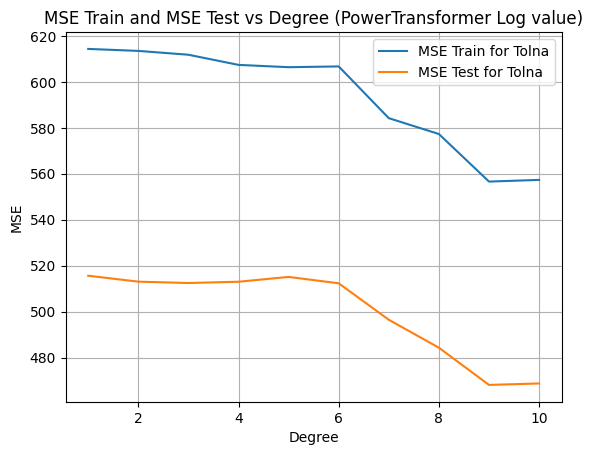

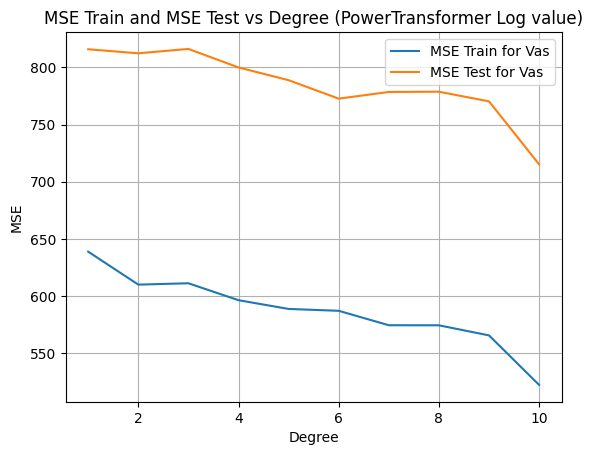

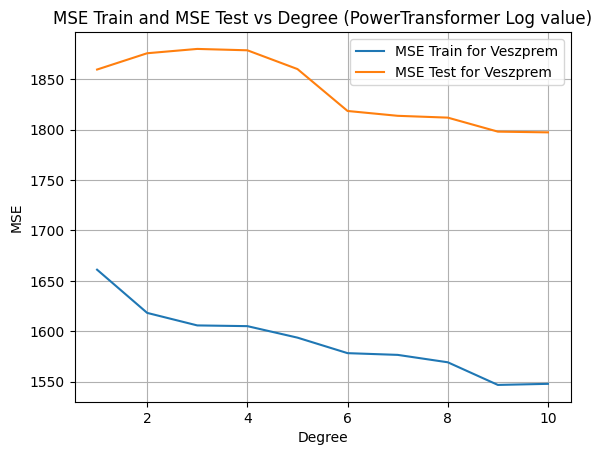

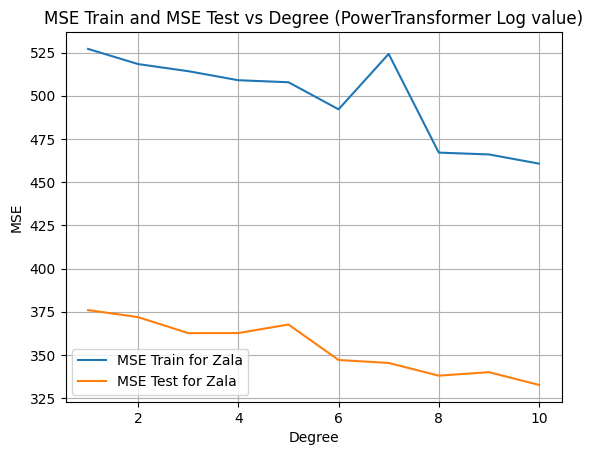

In [132]:
degrees = range(1, 11)
mse_test_pow_log = []
mse_train_pow_log = []

best_degrees_pow_log = []

for county in county_list:

    mse_test_county_pow_log = []
    mse_train_county_pow_log = []  

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        y += 1

        # Logarithmic transformation of y
        y_log = np.log(y)

        # Normalize the target variable
        y_scaled_pow_log = scaler_pow.fit_transform(y_log.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_pow_log, y_test_pow_log = train_test_split(y_scaled_pow_log, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_pow = poly_features.fit_transform(x_train_pow)
        x_test_poly_pow = poly_features.transform(x_test_pow)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_pow, y_train_pow_log)

        # Predict y values for train and test sets
        y_train_pred_pow_log = model.predict(x_train_poly_pow)
        y_test_pred_pow_log = model.predict(x_test_poly_pow)

        # Performing inverse transform so that we have uniform scaling for errors
        y_train_pred_pow_log = scaler_pow.inverse_transform(y_train_pred_pow_log.reshape(-1, 1))
        y_train_pow_log = scaler_pow.inverse_transform(y_train_pow_log.reshape(-1, 1))

        y_test_pred_pow_log = scaler_pow.inverse_transform(y_test_pred_pow_log.reshape(-1, 1))
        y_test_pow_log = scaler_pow.inverse_transform(y_test_pow_log.reshape(-1, 1))

        # Detransforming y_pred_min and y_test_min
        y_train_pred_pow_log = np.exp(y_train_pred_pow_log)
        y_test_pred_pow_log = np.exp(y_test_pred_pow_log)

        y_train_pow_log = np.exp(y_train_pow_log)
        y_test_pow_log = np.exp(y_test_pow_log)

        # calculating errors
        mse_train_county_pow_log.append(mean_squared_error(y_train_pred_pow_log, y_train_pow_log))
        mse_test_county_pow_log.append(mean_squared_error(y_test_pred_pow_log, y_test_pow_log))
        
    mse_test_pow_log.append(np.min(mse_test_county_pow_log))
    mse_train_pow_log.append(mse_test_county_min_log[np.argmin(mse_test_county_pow_log)])
    best_degrees_pow_log.append(np.argmin(mse_test_county_pow_log) + 1)

    plt.plot(degrees, mse_train_county_pow_log, label=f'MSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, mse_test_county_pow_log, label=f'MSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('MSE Train and MSE Test vs Degree (PowerTransformer Log value)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [134]:
new_df_list = {'County': county_list,
               'Best degree (MinMax - No Log)': best_degrees_min,
               'MSE (MinMax - No Log)': mse_test_min,
               'Best degree (MinMax - Log)': best_degrees_min_log,
               'MSE (MinMax - No Log)': mse_test_min_log,
               'Best degree (Power - No Log)': best_degrees_pow,
               'MSE (Power - No Log)': mse_test_pow,
               'Best degree (Power - Log)': best_degrees_pow_log,
               'MSE (Power - No Log)': mse_test_pow_log,
               }

county_with_best_degree = pd.DataFrame(new_df_list)

county_with_best_degree.set_index('County')

Best degree (MinMax - No Log)  MSE (MinMax - No Log)   
County                                                           
BUDAPEST                              3            4957.358586  \
BARANYA                              10            1292.728928   
BACS                                  4            1229.133046   
BEKES                                10             832.953496   
BORSOD                                8            2691.871292   
CSONGRAD                              6             761.955008   
FEJER                                 8            1081.406098   
GYOR                                  6            1285.509363   
HAJDU                                 7            1791.502042   
HEVES                                10             967.203448   
JASZ                                  4            1397.669367   
KOMAROM                               4             580.595152   
NOGRAD                                9             452.264073   
PEST                                  9            4413.505900   
SOMOGY                               10             930.770340   
SZABOLCS                             10            1025.601552   
TOLNA                                 9             442.413085   
VAS                                   9             706.303878   
VESZPREM                             10            1764.959542   
ZALA                                  5             326.855184   

          Best degree (MinMax - Log)  Best degree (Power - No Log)   
County                                                               
BUDAPEST                           5                             6  \
BARANYA                            9                            10   
BACS                              10                            10   
BEKES                              5                             4   
BORSOD                             9                             9   
CSONGRAD                           9                            10   
FEJER                             10                            10   
GYOR                               6                             9   
HAJDU                             10                             6   
HEVES                             10                             8   
JASZ                               9                             9   
KOMAROM                            9                             8   
NOGRAD                            10                            10   
PEST                              10                            10   
SOMOGY                             7                             4   
SZABOLCS                           9                            10   
TOLNA                             10                             9   
VAS                                9                            10   
VESZPREM                          10                             9   
ZALA                              10                            10   

          MSE (Power - No Log)  Best degree (Power - Log)  
County                                                     
BUDAPEST           4338.079773                          6  
BARANYA            1261.534546                         10  
BACS               1174.364021                         10  
BEKES               875.031699                          4  
BORSOD             2617.954679                          9  
CSONGRAD            763.047902                         10  
FEJER              1069.509456                         10  
GYOR               1178.264193                          9  
HAJDU              1749.517181                          6  
HEVES               965.246209                          8  
JASZ               1343.558376                          9  
KOMAROM             572.163700                          8  
NOGRAD              464.548205                         10  
PEST               3968.246548                         10  
SOMOGY              921.562018                          

In [97]:
np.mean(county_with_best_degree['mse(min)'].to_list())

624.9539081471164

In [98]:
np.mean(county_with_best_degree['mse(min)'].to_list())

624.9539081471164

In [99]:
# prediction for next 100 weeks

In [100]:
predictions_df = pd.DataFrame({'Week': np.arange(x.max() + 1, x.max() + 101)})

In [101]:
for i in range(len(county_list)):
    # Extract the target variable for the current county
    y = df[county_list[i]].values

    # Normalize the target variable
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=best_degrees[i])
    x_poly = poly_features.fit_transform(x_scaled)

    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y_scaled)

    # Predict the next 12 weeks
    future_weeks = np.arange(x_scaled.max() + 1, x_scaled.max() + 101)
    future_x = scaler.transform(future_weeks.reshape(-1, 1))
    future_x_poly = poly_features.transform(future_x)
    future_y_scaled = model.predict(future_x_poly)

    # Denormalize the predicted values
    future_y = scaler.inverse_transform(future_y_scaled.reshape(-1, 1)).flatten()

    # Add predictions to the dataframe
    predictions_df[county_list[i]] = future_y

NameError: name 'scaler' is not defined

In [ ]:
predictions_df = predictions_df.round().astype(int)

print("The predictions for next 100 weeks are:")
predictions_df

The predictions for next 100 weeks are:


Week  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0    523       116       74    65    159     134        49     91   121  \
1    524       116       66    65    150     129        37     78   110   
2    525       116       60    64    140     124        28     67   101   
3    526       116       54    64    131     119        22     58    93   
4    527       116       49    63    121     114        18     50    85   
..   ...       ...      ...   ...    ...     ...       ...    ...   ...   
95   618       110       43    37     24      64        34     36    32   
96   619       110       43    37     24      64        34     36    32   
97   620       110       43    37     23      65        33     37    32   
98   621       110       44    37     22      65        33     37    32   
99   622       110       44    37     21      65        32     37    32   

    HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0     153  ...   100       67      16   160      56        45     17   42  \
1     144  ...    96       66      16   153      50        44     13   46   
2     135  ...    93       65      17   146      45        44     12   48   
3     127  ...    90       63      17   140      41        44     13   50   
4     119  ...    87       61      18   134      38        43     15   50   
..    ...  ...   ...      ...     ...   ...     ...       ...    ...  ...   
95     61  ...    45       29      22   112      22        30     14   17   
96     61  ...    45       29      21   111      22        30     16   17   
97     61  ...    45       28      20   110      22        30     17   17   
98     61  ...    46       28      20   110      22        30     18   17   
99     61  ...    46       27      19   109      22        30     19   17   

    VESZPREM  ZALA  
0         89    48  
1         78    41  
2         69    36  
3         62    32  
4         58    29  
..       ...   ...  
95        31    13  
96        31    14  
97        31    14  
98        31    14  
99        31    14  

[100 rows x 21 columns]

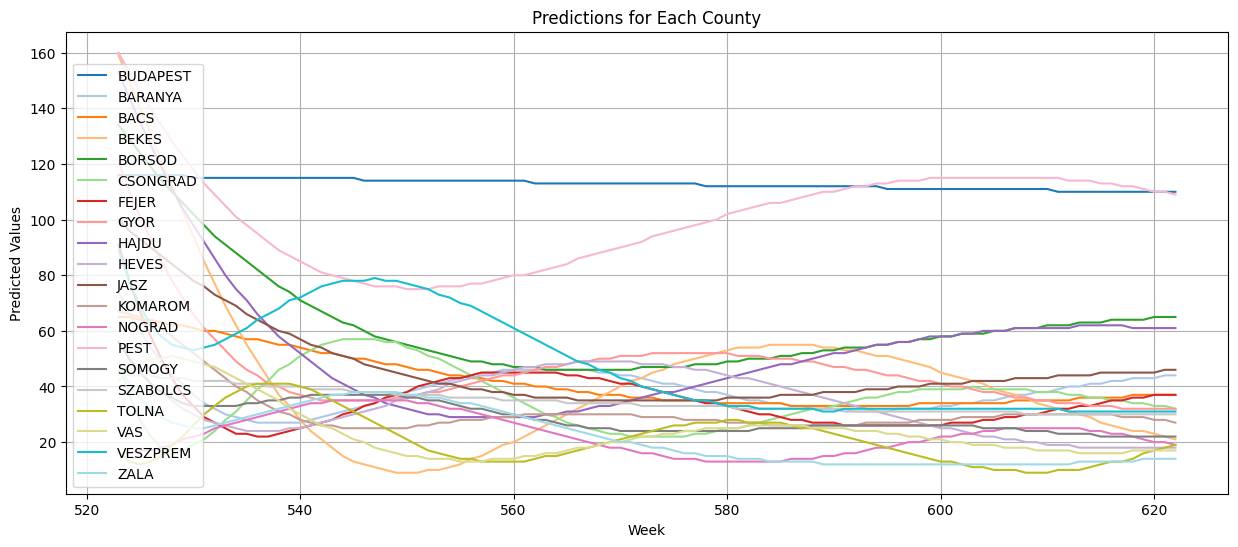

In [ ]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Generate 20 different colors

# Set the figsize
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the predictions for each county with different colors
for i, col in enumerate(predictions_df.columns[1:]):
    plt.plot(predictions_df['Week'], predictions_df[col], label=col, color=colors[i])

plt.xlabel('Week')
plt.ylabel('Predicted Values')
plt.title('Predictions for Each County')
plt.legend()
plt.grid(True)
plt.show()

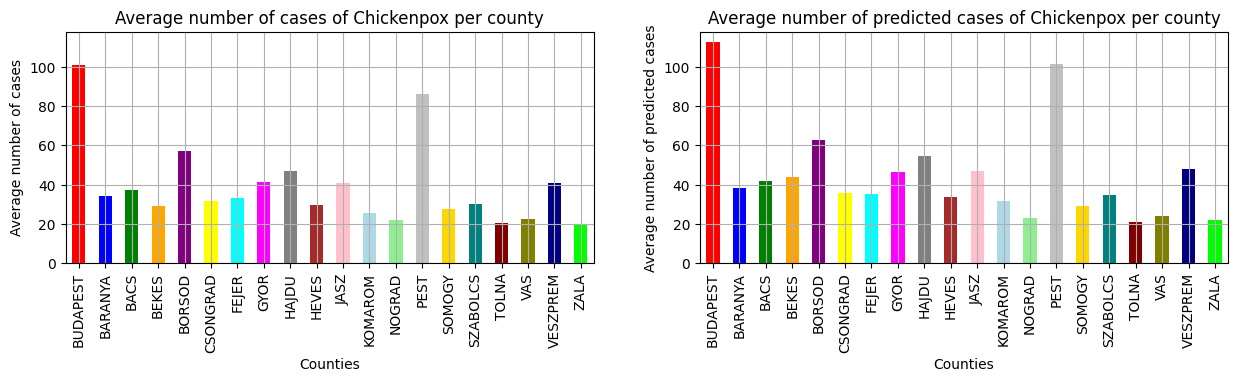

In [ ]:
# Define the colors for the plots
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'gray', 'brown',
          'pink', 'lightblue', 'lightgreen', 'silver', 'gold', 'teal', 'maroon', 'olive', 'navy', 'lime']

# Create subplots with a 1x2 grid layout
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

avg_cases = df[county_list].mean()

avg_predicted_cases = predictions_df[county_list].mean()

if avg_cases.max() > avg_predicted_cases.max():
    max_cases = avg_cases.max()
else:
    max_cases = avg_predicted_cases.max()

# Plot the average number of cases
avg_cases.plot(kind='bar', color=colors, ax=axes[0], grid=True)
axes[0].set_xticklabels(avg_cases.index, rotation=90)
axes[0].set_xlabel('Counties')
axes[0].set_ylabel('Average number of cases')
axes[0].set_title('Average number of cases of Chickenpox per county')
axes[0].set_ylim([0, np.round(max_cases + 5)])  # Set y-axis limits

# Plot the average number of predicted cases
avg_predicted_cases.plot(kind='bar', color=colors, ax=axes[1], grid=True)
axes[1].set_xticklabels(avg_predicted_cases.index, rotation=90)
axes[1].set_xlabel('Counties')
axes[1].set_ylabel('Average number of predicted cases')
axes[1].set_title('Average number of predicted cases of Chickenpox per county')
axes[1].set_ylim([0, np.round(max_cases + 5)])  # Set y-axis limits

# Display the plots
plt.show()

In [ ]:
# using xgboost

In [ ]:
def create_lag_features(data, lag):
    data_copy = data.copy()
    for i in range(1, lag + 1):
        for county in county_list:
            data_copy.loc[:, 'lag_{}'.format(i)] = data_copy[county].shift(i)

    return data_copy

In [ ]:
data = df.drop('Week', axis=1)

data.head()

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   
2  17/01/2005        96       44    31     86      93        30     93    84   
3  24/01/2005       163       49    43    126      46        39     52   114   
4  31/01/2005       122       78    53     87     103        34     95   131   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   
3    107  ...    63       54      14   107      66        50     25   21   
4    172  ...    61       49      11   124      63        56      7   47   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  
3        43    31  
4        85    60  

[5 rows x 21 columns]

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

data.head()

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0 2005-01-03       168       79    30    173     169        42    136   120  \
1 2005-01-10       157       60    30     92     200        53     51    70   
2 2005-01-17        96       44    31     86      93        30     93    84   
3 2005-01-24       163       49    43    126      46        39     52   114   
4 2005-01-31       122       78    53     87     103        34     95   131   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   
3    107  ...    63       54      14   107      66        50     25   21   
4    172  ...    61       49      11   124      63        56      7   47   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  
3        43    31  
4        85    60  

[5 rows x 21 columns]

In [ ]:
# Assuming 'Date' is the column name for dates and 'BUDAPEST' is the target county
x1 = data.drop(['Date'], axis=1)
y1 = data['BUDAPEST']

x1.head()

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR  HAJDU   
0       168       79    30    173     169        42    136   120    162  \
1       157       60    30     92     200        53     51    70     84   
2        96       44    31     86      93        30     93    84    191   
3       163       49    43    126      46        39     52   114    107   
4       122       78    53     87     103        34     95   131    172   

   HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS  VESZPREM   
0     36   130       57       2   178      66        64     11   29        87  \
1     28    80       50      29   141      48        29     58   53        68   
2     51    64       46       4   157      33        33     24   18        62   
3     42    63       54      14   107      66        50     25   21        43   
4     40    61       49      11   124      63        56      7   47        85   

   ZALA  
0    68  
1    26  
2    44  
3    31  
4    60

In [ ]:
scaler = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()
scaler4 = PowerTransformer()
x1_scaled_df = pd.DataFrame(scaler.fit_transform(x1), columns=x1.columns)
x1_scaled = scaler.fit_transform(x1)

x1_scaled_df2 = pd.DataFrame(scaler2.fit_transform(x1), columns=x1.columns)
x1_scaled_df3 = pd.DataFrame(scaler3.fit_transform(x1), columns=x1.columns)
x1_scaled_df4 = pd.DataFrame(scaler4.fit_transform(x1), columns=x1.columns)

x1_scaled_df.head()

BUDAPEST   BARANYA      BACS     BEKES    BORSOD  CSONGRAD     FEJER   
0  0.875109  1.376783 -0.194705  3.833962  2.208458  0.311379  3.274939  \
1  0.730906  0.792814 -0.194705  1.678677  2.820177  0.637230  0.565163   
2 -0.068761  0.301052 -0.167537  1.519027  0.708758 -0.044094  1.904111   
3  0.809562  0.454727  0.158481  2.583365 -0.218687  0.222511  0.597042   
4  0.272081  1.346048  0.430163  1.545635  0.906087  0.074397  1.967871   

       GYOR     HAJDU     HEVES      JASZ   KOMAROM    NOGRAD      PEST   
0  2.183538  2.578130  0.198209  2.392915  1.282753 -0.902098  1.377587  \
1  0.793869  0.827998 -0.053149  1.050546  0.996391  0.324902  0.822945   
2  1.182976  3.228819  0.669503  0.620987  0.832755 -0.811209  1.062790   
3  2.016777  1.344063  0.386726  0.594140  1.160026 -0.356765  0.313275   
4  2.489265  2.802505  0.323887  0.540445  0.955482 -0.493098  0.568110   

     SOMOGY  SZABOLCS     TOLNA       VAS  VESZPREM      ZALA  
0  1.437932  1.074297 -0.402245  0.261484  1.140272  2.189700  
1  0.763740 -0.026882  1.619197  1.222150  0.672987  0.278746  
2  0.201913  0.098967  0.156877 -0.178821  0.525424  1.097726  
3  1.437932  0.633825  0.199887 -0.058738  0.058140  0.506241  
4  1.325567  0.822599 -0.574283  0.981983  1.091084  1.825709

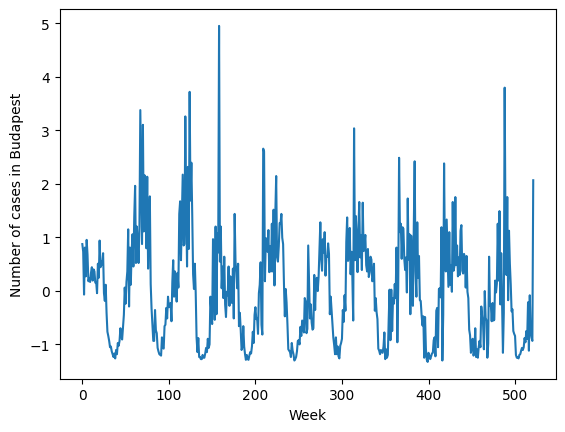

In [ ]:
plt.plot(x1_scaled_df.reset_index()['index'], x1_scaled_df["BUDAPEST"])
# plt.plot(x1.reset_index()['index'], x1["BUDAPEST"])
plt.xlabel("Week")
plt.ylabel("Number of cases in Budapest")
plt.show()

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x1_scaled)

# Analyze the results
explained_variance_ratio = pca.explained_variance_ratio_
principal_components = pca.components_

print(str(explained_variance_ratio) + ', ' + str(principal_components))

[0.52821904 0.06386191], [[ 0.25540714  0.23219596  0.21940954  0.20718542  0.23054928  0.20280915
   0.22472427  0.25712867  0.23045989  0.20969899  0.23850431  0.2401598
   0.20428735  0.26505039  0.22318101  0.20431084  0.18986726  0.19226737
   0.23588862  0.18719314]
 [ 0.11689323 -0.01979717 -0.1684213  -0.27572587 -0.13636651  0.29025875
  -0.33082303 -0.21976518 -0.25301666 -0.12161086 -0.03665758 -0.18241052
   0.23110136  0.04140323  0.20413404 -0.15457606  0.4266892   0.33201344
   0.21015293  0.22448961]]


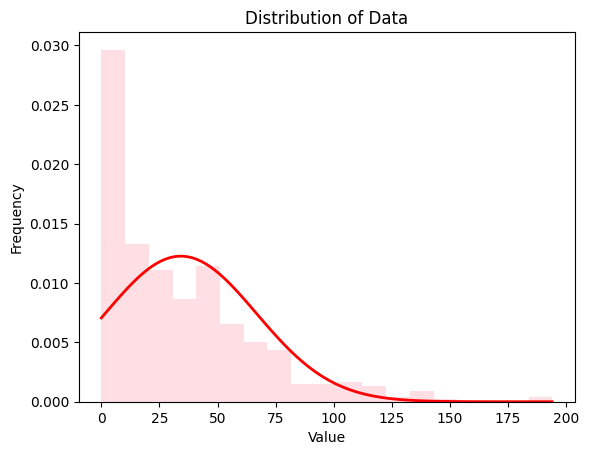

In [ ]:
# Plot the histogram of the data
plt.hist(x1['BARANYA'].values, bins='auto', density=True, alpha=0.5, color='pink')

# Fit a Gaussian distribution to the data
mu, sigma = stats.norm.fit(x1['BARANYA'].values)

# Generate points on the x-axis for the Gaussian distribution curve
x = np.linspace(min(x1['BARANYA'].values), max(x1['BARANYA'].values), 100)
# Calculate the corresponding y-values from the fitted Gaussian distribution
y = stats.norm.pdf(x, mu, sigma)

# Plot the Gaussian distribution curve
plt.plot(x, y, 'r-', linewidth=2)

# Add labels and title to the plot
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

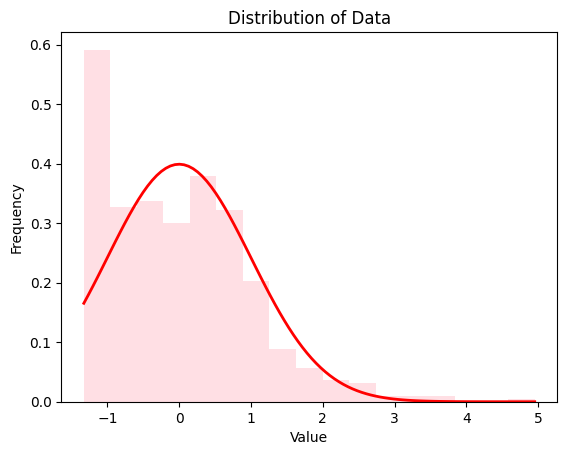

In [ ]:
# Plot the histogram of the data
plt.hist(x1_scaled_df['BUDAPEST'].values, bins='auto', density=True, alpha=0.5, color='pink')

# Fit a Gaussian distribution to the data
mu, sigma = stats.norm.fit(x1_scaled_df['BUDAPEST'].values)

# Generate points on the x-axis for the Gaussian distribution curve
x = np.linspace(min(x1_scaled_df['BUDAPEST'].values), max(x1_scaled_df['BUDAPEST'].values), 100)
# Calculate the corresponding y-values from the fitted Gaussian distribution
y = stats.norm.pdf(x, mu, sigma)

# Plot the Gaussian distribution curve
plt.plot(x, y, 'r-', linewidth=2)

# Add labels and title to the plot
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

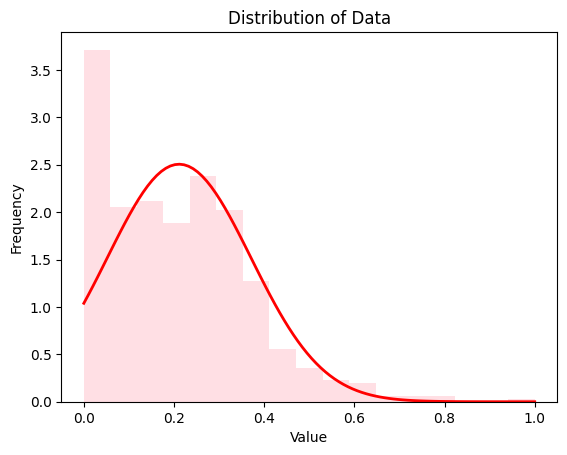

In [ ]:
# Plot the histogram of the data
plt.hist(x1_scaled_df2['BUDAPEST'].values, bins='auto', density=True, alpha=0.5, color='pink')

# Fit a Gaussian distribution to the data
mu, sigma = stats.norm.fit(x1_scaled_df2['BUDAPEST'].values)

# Generate points on the x-axis for the Gaussian distribution curve
x = np.linspace(min(x1_scaled_df2['BUDAPEST'].values), max(x1_scaled_df2['BUDAPEST'].values), 100)
# Calculate the corresponding y-values from the fitted Gaussian distribution
y = stats.norm.pdf(x, mu, sigma)

# Plot the Gaussian distribution curve
plt.plot(x, y, 'r-', linewidth=2)

# Add labels and title to the plot
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

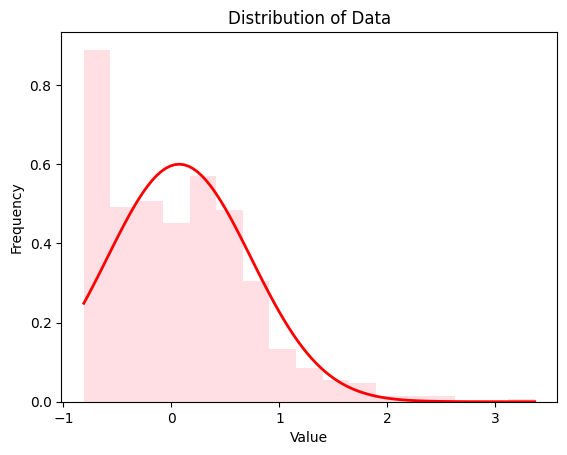

In [ ]:
# Plot the histogram of the data
plt.hist(x1_scaled_df3['BUDAPEST'].values, bins='auto', density=True, alpha=0.5, color='pink')

# Fit a Gaussian distribution to the data
mu, sigma = stats.norm.fit(x1_scaled_df3['BUDAPEST'].values)

# Generate points on the x-axis for the Gaussian distribution curve
x = np.linspace(min(x1_scaled_df3['BUDAPEST'].values), max(x1_scaled_df3['BUDAPEST'].values), 100)
# Calculate the corresponding y-values from the fitted Gaussian distribution
y = stats.norm.pdf(x, mu, sigma)

# Plot the Gaussian distribution curve
plt.plot(x, y, 'r-', linewidth=2)

# Add labels and title to the plot
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

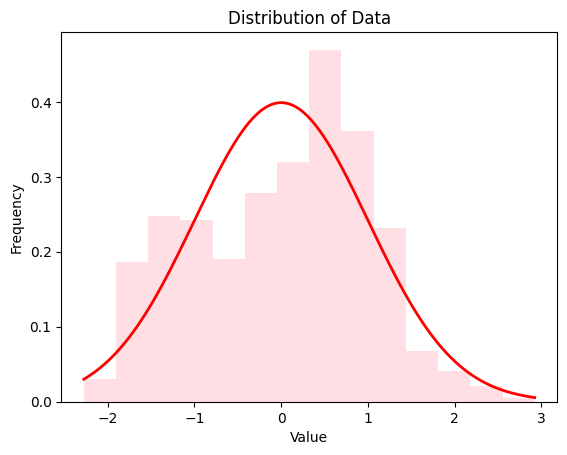

In [ ]:
# Plot the histogram of the data
plt.hist(x1_scaled_df4['BUDAPEST'].values, bins='auto', density=True, alpha=0.5, color='pink')

# Fit a Gaussian distribution to the data
mu, sigma = stats.norm.fit(x1_scaled_df4['BUDAPEST'].values)

# Generate points on the x-axis for the Gaussian distribution curve
x = np.linspace(min(x1_scaled_df4['BUDAPEST'].values), max(x1_scaled_df4['BUDAPEST'].values), 500)
# Calculate the corresponding y-values from the fitted Gaussian distribution
y = stats.norm.pdf(x, mu, sigma)

# Plot the Gaussian distribution curve
plt.plot(x, y, 'r-', linewidth=2)

# Add labels and title to the plot
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

In [ ]:


# Load the CSV file
data = pd.read_csv('hungary_chickenpox.csv')

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = data[:train_size], data[train_size:]

# Create lag features for each county
def create_lag_features(data, lag):
    lagged_data = data.copy()
    for col in data.columns:
        for i in range(1, lag+1):
            lagged_data[f'lag_{i}_{col}'] = data[col].shift(i)
    return lagged_data

lag = 4  # Adjust the lag as per your requirements
train_lagged = create_lag_features(train_data, lag)
test_lagged = create_lag_features(test_data, lag)

# Prepare the input features and target variables
X_train, y_train = train_lagged.dropna().drop(data.columns, axis=1), train_lagged.dropna()[data.columns]
X_test, y_test = test_lagged.dropna().drop(data.columns, axis=1), test_lagged.dropna()[data.columns]

# Train separate XGBoost models for each county
models = {}
for col in data.columns:
    model = XGBRegressor()
    model.fit(X_train, y_train[col])
    models[col] = model

# Perform time series cross-validation for each county
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    for col in data.columns:
        model = models[col]
        model.fit(X_train_fold, y_train_fold[col])
        y_val_pred = model.predict(X_val_fold)
        print(f'Validation RMSE for {col}:', np.sqrt(mean_squared_error(y_val_fold[col], y_val_pred)))

Validation RMSE for BUDAPEST: 59.653685066920985
Validation RMSE for BARANYA: 27.2002522241138
Validation RMSE for BACS: 26.61530582911033
Validation RMSE for BEKES: 37.261473498604175
Validation RMSE for BORSOD: 46.79381043177941
Validation RMSE for CSONGRAD: 23.014346359105957
Validation RMSE for FEJER: 23.756563715106424
Validation RMSE for GYOR: 29.176106064033124
Validation RMSE for HAJDU: 36.09582722327727
Validation RMSE for HEVES: 55.88695684904089
Validation RMSE for JASZ: 31.871097109692503
Validation RMSE for KOMAROM: 26.043247361313835
Validation RMSE for NOGRAD: 29.4573671500028
Validation RMSE for PEST: 51.270116610939375
Validation RMSE for SOMOGY: 18.46268987069644
Validation RMSE for SZABOLCS: 22.265636716510592
Validation RMSE for TOLNA: 26.81868198645564
Validation RMSE for VAS: 19.662725682850624
Validation RMSE for VESZPREM: 23.60491999366466
Validation RMSE for ZALA: 12.87530518264277
Validation RMSE for BUDAPEST: 77.03744845640199
Validation RMSE for BARANYA: 23.

In [ ]:
model = XGBRegressor()

In [ ]:
model.learning_rate = 0.00001  # Learning rate
model.max_depth = 10  # Maximum depth of each tree
model.n_estimators = 500  # Number of trees (boosting rounds)
model.reg_alpha = 0.05  # L1 regularization term
model.reg_lambda = 0.1  # L2 regularization term

In [ ]:
# Load the CSV file
data = pd.read_csv('hungary_chickenpox.csv')

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)

data = pd.DataFrame(scaler4.fit_transform(data), columns=data.columns)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.35, random_state=42)

# Create lag features for each county
def create_lag_features(data, lag):
    lagged_data = data.copy()
    for col in data.columns:
        for i in range(1, lag+1):
            lagged_data[f'lag_{i}_{col}'] = data[col].shift(i)
            lagged_data[f'lag_{i}_{col}'].fillna(method='backfill', inplace=True)  # Use backfill to fill NaN values
    return lagged_data

lag = 3  # Adjust the lag as per your requirements
train_lagged = create_lag_features(train_data, lag)
test_lagged = create_lag_features(test_data, lag)

# Prepare the input features and target variables
X_train, y_train = train_lagged.dropna().drop(data.columns, axis=1), train_lagged.dropna()[data.columns]
X_test, y_test = test_lagged.dropna().drop(data.columns, axis=1), test_lagged.dropna()[data.columns]

y_test

BUDAPEST   BARANYA      BACS     BEKES    BORSOD  CSONGRAD     FEJER   
434  0.474770  0.821566  0.651495  0.845175 -0.051175 -1.469686  0.379722  \
440  0.517691  0.673144  0.305703  0.508101  0.616791 -0.324056  0.292860   
6    0.788802  1.594413  0.730972  2.126236  1.472841  1.098000  1.581970   
184 -1.281529 -0.764623 -0.713470 -0.056794 -0.123772 -0.120717 -0.737105   
78   1.480831  1.115296  0.011498 -0.677562  0.186431  0.288656 -0.009832   
..        ...       ...       ...       ...       ...       ...       ...   
60   1.257926  0.759744  0.691775  0.090907  1.099822  1.378045  0.634750   
110  0.528299  0.900292  1.059957  1.661906  0.225690  0.257382  0.434644   
331  0.463914 -0.247649  1.028432  1.014530  0.969464  1.188383  0.929554   
274  0.854499  1.275077  1.532212  0.134788  0.225690 -0.382587  0.379722   
29  -0.637198 -0.502563 -0.856815 -0.237382 -0.719105 -0.752625 -0.417321   

         GYOR     HAJDU     HEVES      JASZ   KOMAROM    NOGRAD      PEST   
434  0.596493  1.260147  0.611021  0.110196 -0.017285  0.691090  0.653140  \
440 -0.315844  0.167881 -0.458271 -0.140967  0.440113  1.286278  0.391635   
6    1.610899  1.487680  0.685565  1.189415  1.194729 -0.249189  0.653140   
184 -0.240582  0.213913 -0.607823 -0.413548  0.031733 -0.988311 -1.075678   
78   1.610899  0.784362  0.024467 -0.176247  0.837070  0.010996  0.288141   
..        ...       ...       ...       ...       ...       ...       ...   
60   1.105131  1.103303  0.024467  0.980773  1.129296  1.107085  0.877858   
110  0.973367 -0.179789  1.838466  1.656857  0.440113  1.426625  0.247957   
331  0.718039  1.382847  1.539796  0.778451  0.031733 -0.325772  1.185623   
274  0.990337  0.480609 -0.162482  0.587580  1.106891 -0.177911  0.908333   
29  -0.526571 -0.458332 -0.329123 -0.073326  0.124330 -1.171182 -0.923085   

       SOMOGY  SZABOLCS     TOLNA       VAS  VESZPREM      ZALA  
434  1.147490  0.840626  1.353089  0.133766  0.371768 -1.330769  
440  0.599864  1.317544  0.703714  0.399788  0.174049 -0.590387  
6    1.875293  1.452853  0.451010  0.757045  1.823146  1.660352  
184 -0.548750  0.508258  0.765744 -0.316366 -0.978782  0.080139  
78   0.028343  0.613170  0.671241  0.510130  0.226649  0.668671  
..        ...       ...       ...       ...       ...       ...  
60   2.070537  1.150746  1.353089  1.653680  2.033392  1.751012  
110  1.186863  0.508258  0.765744  0.861770  0.826632  0.947329  
331  0.115565  1.918866  0.529896  0.081356  1.333189  0.861641  
274  0.196975  0.156118  0.932386  0.230707  0.348762 -0.475296  
29  -0.406239 -0.007027 -0.240353 -0.236763 -0.819355 -0.197453  

[183 rows x 20 columns]

In [ ]:


# Train the XGBoost model for each county and calculate MAPE
mape_scores = {}
smape_scores = {}
for county in data.columns:    
    model.fit(X_train, y_train[county])
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test[county], y_pred)
    smape = calculate_smape(y_test[county], y_pred)
    mape_scores[county] = mape
    smape_scores[county] = smape

    print(y_test[county])

    # Plot the results
    # plt.plot(y_test[county], label='Actual')
    # plt.plot(y_pred, label='Predicted')
    # plt.xlabel('Time')
    # plt.ylabel('Count')
    # plt.legend()
    # plt.show()


# Print overall MAPE score for each county
for county, mape in mape_scores.items():
    print(f"County: {county}, MAPE: {mape}, SMAPE: {smape_scores[county]}")
    


434    0.474770
440    0.517691
6      0.788802
184   -1.281529
78     1.480831
         ...   
60     1.257926
110    0.528299
331    0.463914
274    0.854499
29    -0.637198
Name: BUDAPEST, Length: 183, dtype: float64
434    0.821566
440    0.673144
6      1.594413
184   -0.764623
78     1.115296
         ...   
60     0.759744
110    0.900292
331   -0.247649
274    1.275077
29    -0.502563
Name: BARANYA, Length: 183, dtype: float64
434    0.651495
440    0.305703
6      0.730972
184   -0.713470
78     0.011498
         ...   
60     0.691775
110    1.059957
331    1.028432
274    1.532212
29    -0.856815
Name: BACS, Length: 183, dtype: float64
434    0.845175
440    0.508101
6      2.126236
184   -0.056794
78    -0.677562
         ...   
60     0.090907
110    1.661906
331    1.014530
274    0.134788
29    -0.237382
Name: BEKES, Length: 183, dtype: float64
434   -0.051175
440    0.616791
6      1.472841
184   -0.123772
78     0.186431
         ...   
60     1.099822
110    0.225690


In [ ]:


# Load the CSV file
data = pd.read_csv('hungary_chickenpox.csv')

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.rename(columns={'Date': 'ds'}, inplace=True)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.35, random_state=42)

# Prepare the target variable
target_col = 'PEST'  # Choose the county for analysis
train_target = train_data[['ds', target_col]].rename(columns={'ds': 'ds', target_col: 'y'})

# Train the Prophet model
model = Prophet()
model.add_seasonality(name='weekly', period=7, fourier_order=10, mode='additive')
model.fit(train_target)

# Generate future dates for prediction
future = model.make_future_dataframe(periods=len(test_data), freq='W')

# Perform predictions
forecast = model.predict(future)

# Extract the predicted values
y_pred = forecast['yhat'].tail(len(test_data))

# Prepare the true values for evaluation
y_true = test_data[[target_col]].reset_index(drop=True)

# Calculate MAPE
smape = calculate_smape(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"County: {target_col}, SMAPE: {smape}, MAPE: {mape}")


c:\Users\unnat\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
18:29:44 - cmdstanpy - INFO - Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing


County: PEST, SMAPE: 0.0, MAPE: 983174804604904.2


In [ ]:


# Load and preprocess the data
data = pd.read_csv('hungary_chickenpox.csv', parse_dates=['Date'], index_col='Date')
#data = data.asfreq('W')  # Set frequency to weekly
data = data['BARANYA']  # Assuming the target variable is 'Count'

data

Date
03/01/2005    79
10/01/2005    60
17/01/2005    44
24/01/2005    49
31/01/2005    78
              ..
01/12/2014    12
08/12/2014    39
15/12/2014     7
22/12/2014    23
29/12/2014    42
Name: BARANYA, Length: 522, dtype: int64

Epoch 1/100
13/13 [==============================] - 10s 47ms/step - loss: 0.0274
Epoch 2/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0190
Epoch 3/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0172
Epoch 4/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0166
Epoch 5/100
13/13 [==============================] - 1s 38ms/step - loss: 0.0157
Epoch 6/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0142
Epoch 7/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0125
Epoch 8/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0124
Epoch 9/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0119
Epoch 10/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0108
Epoch 11/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0112
Epoch 12/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0106
Epoch 13/100
13/13 [====

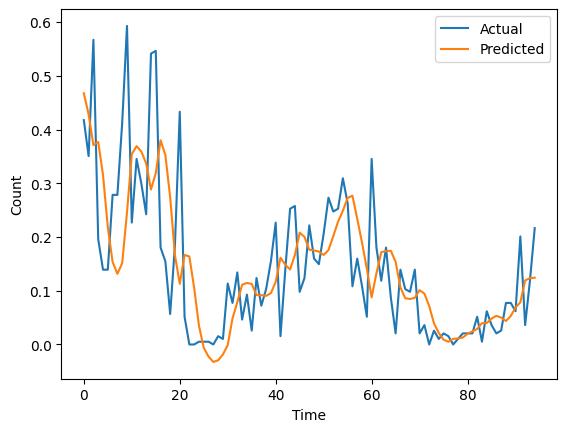

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

# Prepare the training data
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

# Build the RNN model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
# predictions = scaler.inverse_transform(predictions)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE
#mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
smape = calculate_smape(y_test, predictions)
mse1 = mean_squared_error(y_test, predictions)
print(f"MAPE: inf, SMAPE: {smape}, mse = {mse1}")

# Plot the results
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()